# Analysis of the spectral signature of each sensor

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

from tqdm import tqdm
import json
from pathlib import Path

### 1. For one sample

In [2]:
def to_dask(shot: int, group: str = "efm", level: int = 1) -> xr.Dataset:
    """
    Return a Dataset from the MAST Zarr store.

    Parameters
    shot: Shot ID to retrieve data for.
    group: Diagnostic group to retrieve data from (default is "efm").
    level: Data level to retrieve (default is 1).
    """
    return xr.open_zarr(
        f"https://s3.echo.stfc.ac.uk/mast/level{level}/shots/{shot}.zarr",
        group=group,
    )

In [3]:
ds = to_dask(24000, group="magnetics", level=2)
ds

<xarray.Dataset> Size: 42MB
Dimensions:                                   (b_field_pol_probe_cc_channel: 5,
                                               time_mirnov: 340901,
                                               b_field_pol_probe_ccbv_channel: 40,
                                               time: 3410,
                                               b_field_pol_probe_obr_channel: 18,
                                               b_field_pol_probe_obv_channel: 18,
                                               b_field_pol_probe_omv_channel: 3,
                                               b_field_tor_probe_cc_channel: 3,
                                               b_field_tor_probe_saddle_field_channel: 12,
                                               time_saddle: 34091,
                                               b_field_tor_probe_saddle_voltage_channel: 12,
                                               flux_loop_channel: 15)
Coordinates:
  * b_field_pol_probe_cc_channel              (b_field_pol_probe_cc_channel) <U13 260B ...
  * b_field_pol_probe_ccbv_channel            (b_field_pol_probe_ccbv_channel) <U10 2kB ...
  * b_field_pol_probe_obr_channel             (b_field_pol_probe_obr_channel) <U9 648B ...
  * b_field_pol_probe_obv_channel             (b_field_pol_probe_obv_channel) <U9 648B ...
  * b_field_pol_probe_omv_channel             (b_field_pol_probe_omv_channel) <U11 132B ...
  * b_field_tor_probe_cc_channel              (b_field_tor_probe_cc_channel) <U13 156B ...
  * b_field_tor_probe_saddle_field_channel    (b_field_tor_probe_saddle_field_channel) <U11 528B ...
  * b_field_tor_probe_saddle_voltage_channel  (b_field_tor_probe_saddle_voltage_channel) <U15 720B ...
  * flux_loop_channel                         (flux_loop_channel) <U12 720B '...
  * time                                      (time) float64 27kB -0.0988 ......
  * time_mirnov                               (time_mirnov) float64 3MB -0.09...
  * time_saddle                               (time_saddle) float64 273kB -0....
Data variables:
    b_field_pol_probe_cc_field                (b_field_pol_probe_cc_channel, time_mirnov) float64 14MB ...
    b_field_pol_probe_ccbv_field              (b_field_pol_probe_ccbv_channel, time) float64 1MB ...
    b_field_pol_probe_obr_field               (b_field_pol_probe_obr_channel, time) float64 491kB ...
    b_field_pol_probe_obv_field               (b_field_pol_probe_obv_channel, time) float64 491kB ...
    b_field_pol_probe_omv_voltage             (b_field_pol_probe_omv_channel, time_mirnov) float64 8MB ...
    b_field_tor_probe_cc_field                (b_field_tor_probe_cc_channel, time_mirnov) float64 8MB ...
    b_field_tor_probe_saddle_field            (b_field_tor_probe_saddle_field_channel, time_saddle) float64 3MB ...
    b_field_tor_probe_saddle_voltage          (b_field_tor_probe_saddle_voltage_channel, time_saddle) float64 3MB ...
    flux_loop_flux                            (flux_loop_channel, time) float64 409kB ...
    ip                                        (time) float64 27kB ...
Attributes:
    description:  
    imas:         magnetics
    label:        Plasma Current
    name:         magnetics
    uda_name:     AMC_PLASMA CURRENT
    units:        A

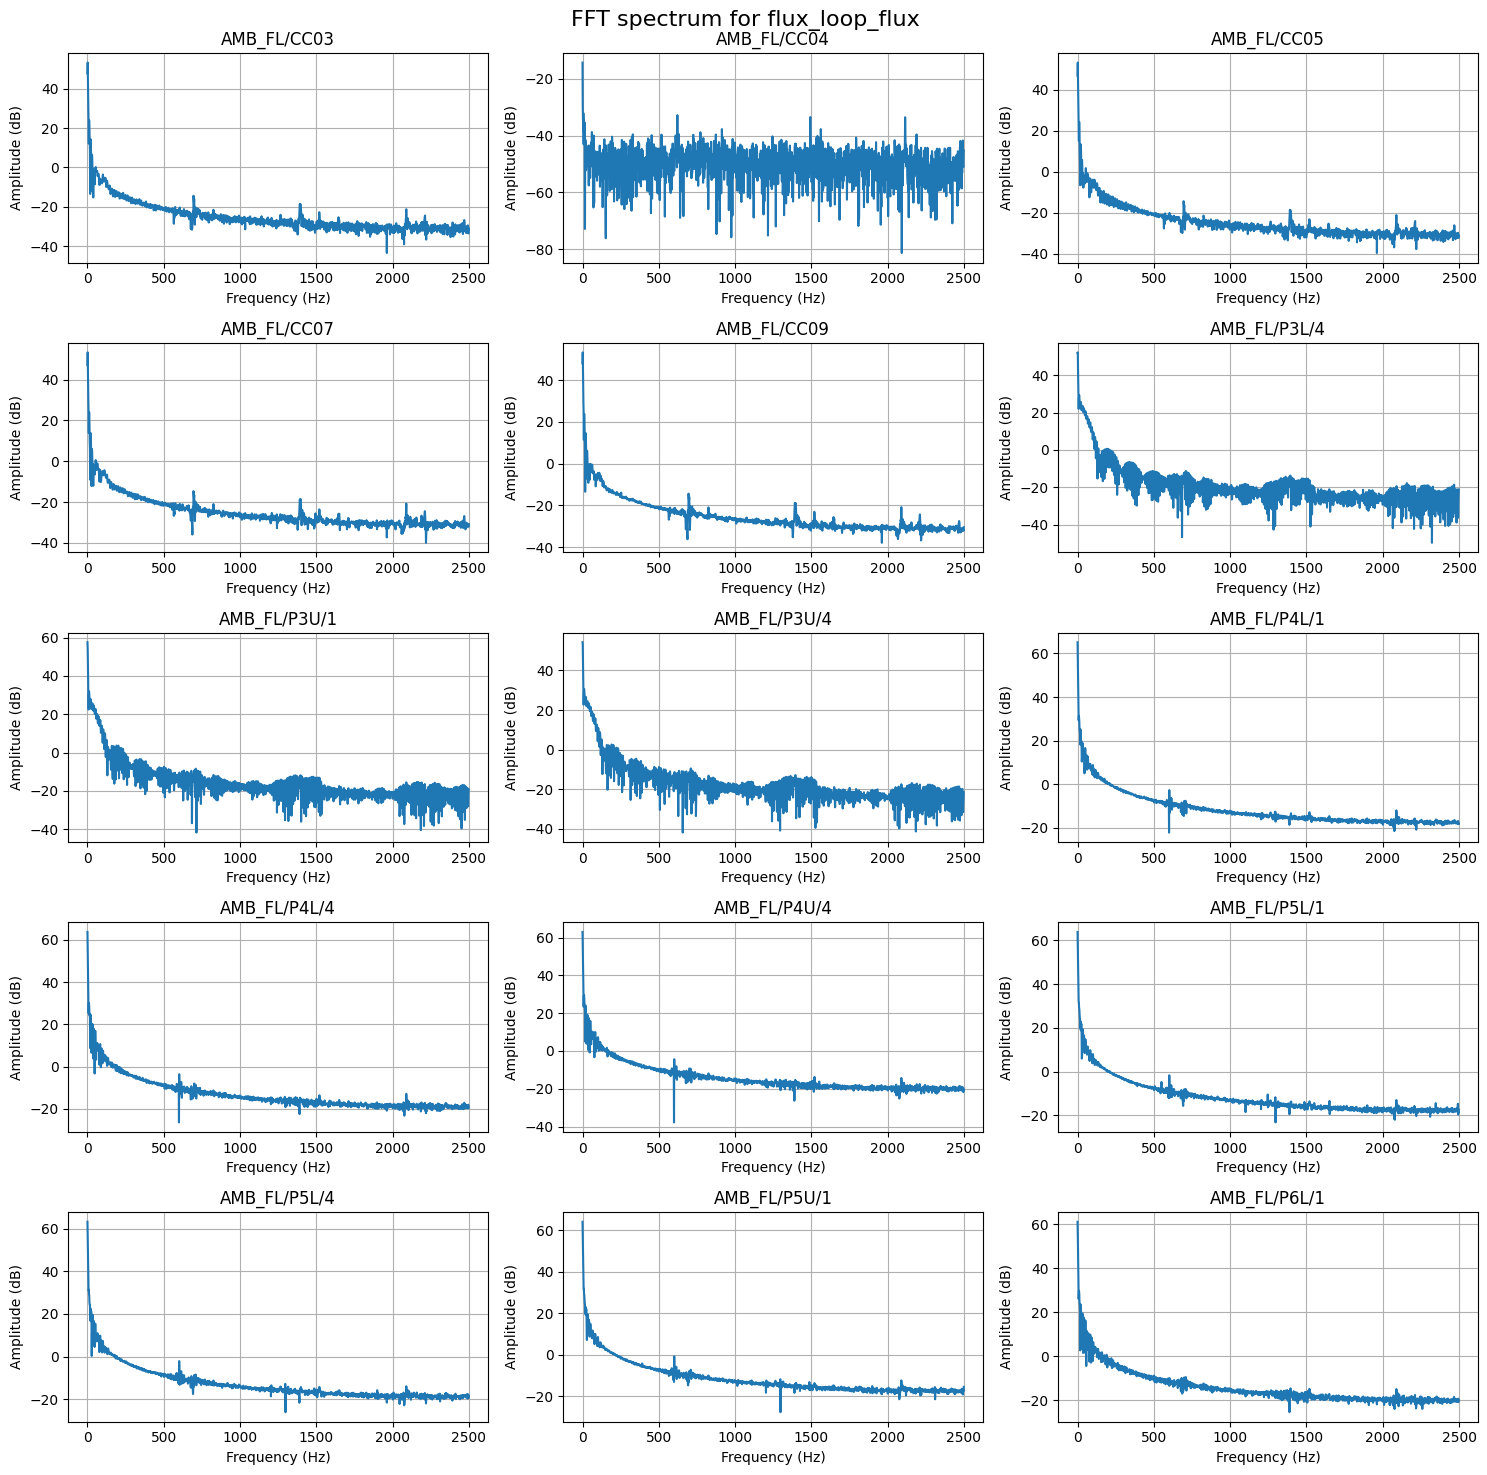

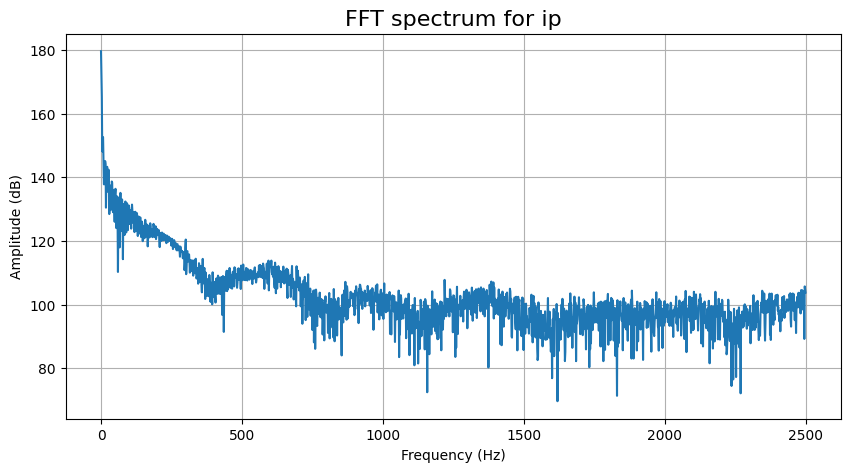

In [4]:
def plot_fft_variable(ds: xr.Dataset, chosen_var: str):
    da = ds[chosen_var]
    
    channel_dim, time_dim = None, None
    for dim in da.dims:
        if 'channel' in dim:
            channel_dim = dim
        elif 'time' in dim:
            time_dim = dim
    if time_dim is None:
        raise ValueError("No time dimension found in the variable.")
    if channel_dim is None:
        # Case for unique channel in variable
        time_values = da[time_dim].values
        Fs = 1 / np.mean(np.diff(time_values))
        fig, ax = plt.subplots(figsize=(10, 5))
        fft_result = np.fft.fft(da.values)
        freqs = np.fft.fftfreq(len(da.values), 1/Fs)
        positive_freqs = freqs[:len(freqs)//2]
        magnitude = np.abs(fft_result[:len(fft_result)//2])
        magnitude_db = 20 * np.log10(magnitude + 1e-10)
        ax.plot(positive_freqs, magnitude_db)
        ax.set_title(f'FFT spectrum for {chosen_var}', fontsize=16)
        ax.set_xlabel('Frequency (Hz)')
        ax.set_ylabel('Amplitude (dB)')
        ax.grid(True)
        plt.show()
        return None
    
    time_values = da[time_dim].values
    Fs = 1 / np.mean(np.diff(time_values))  # Sampling frequency
    n_chan = da.sizes[channel_dim]
    
    n_rows = (n_chan + 2) // 3
    fig, axs = plt.subplots(n_rows, 3, figsize=(15, 3 * n_rows))
    axs = axs.flatten()
    
    for i in range(n_chan):
        channel_data = da.isel({channel_dim: i}).values
        fft_result = np.fft.fft(channel_data)
        freqs = np.fft.fftfreq(len(channel_data), 1/Fs)
        
        # Half-spectrum: positive frequencies only
        positive_freqs = freqs[:len(freqs)//2]
        magnitude = np.abs(fft_result[:len(fft_result)//2])
        magnitude_db = 20 * np.log10(magnitude + 1e-10)  # Decibel scale + avoid log(0)
        
        # Plotting
        axs[i].plot(positive_freqs, magnitude_db)
        axs[i].set_title(f'{da[channel_dim].values[i]}')
        axs[i].set_xlabel('Frequency (Hz)')
        axs[i].set_ylabel('Amplitude (dB)')
        axs[i].grid(True)
    
    plt.suptitle(f'FFT spectrum for {chosen_var}', fontsize=16)
    # Hide unused subplots
    for j in range(n_chan, len(axs)):
        axs[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    return None

plot_fft_variable(ds, 'flux_loop_flux')
plot_fft_variable(ds, 'ip')

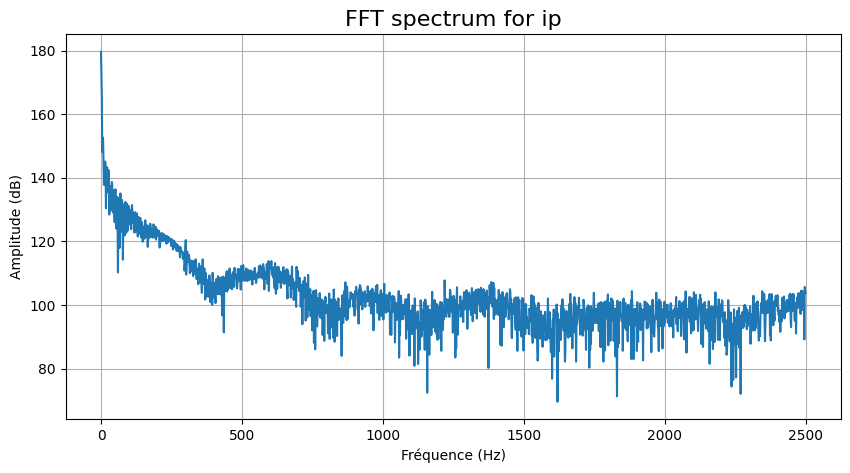

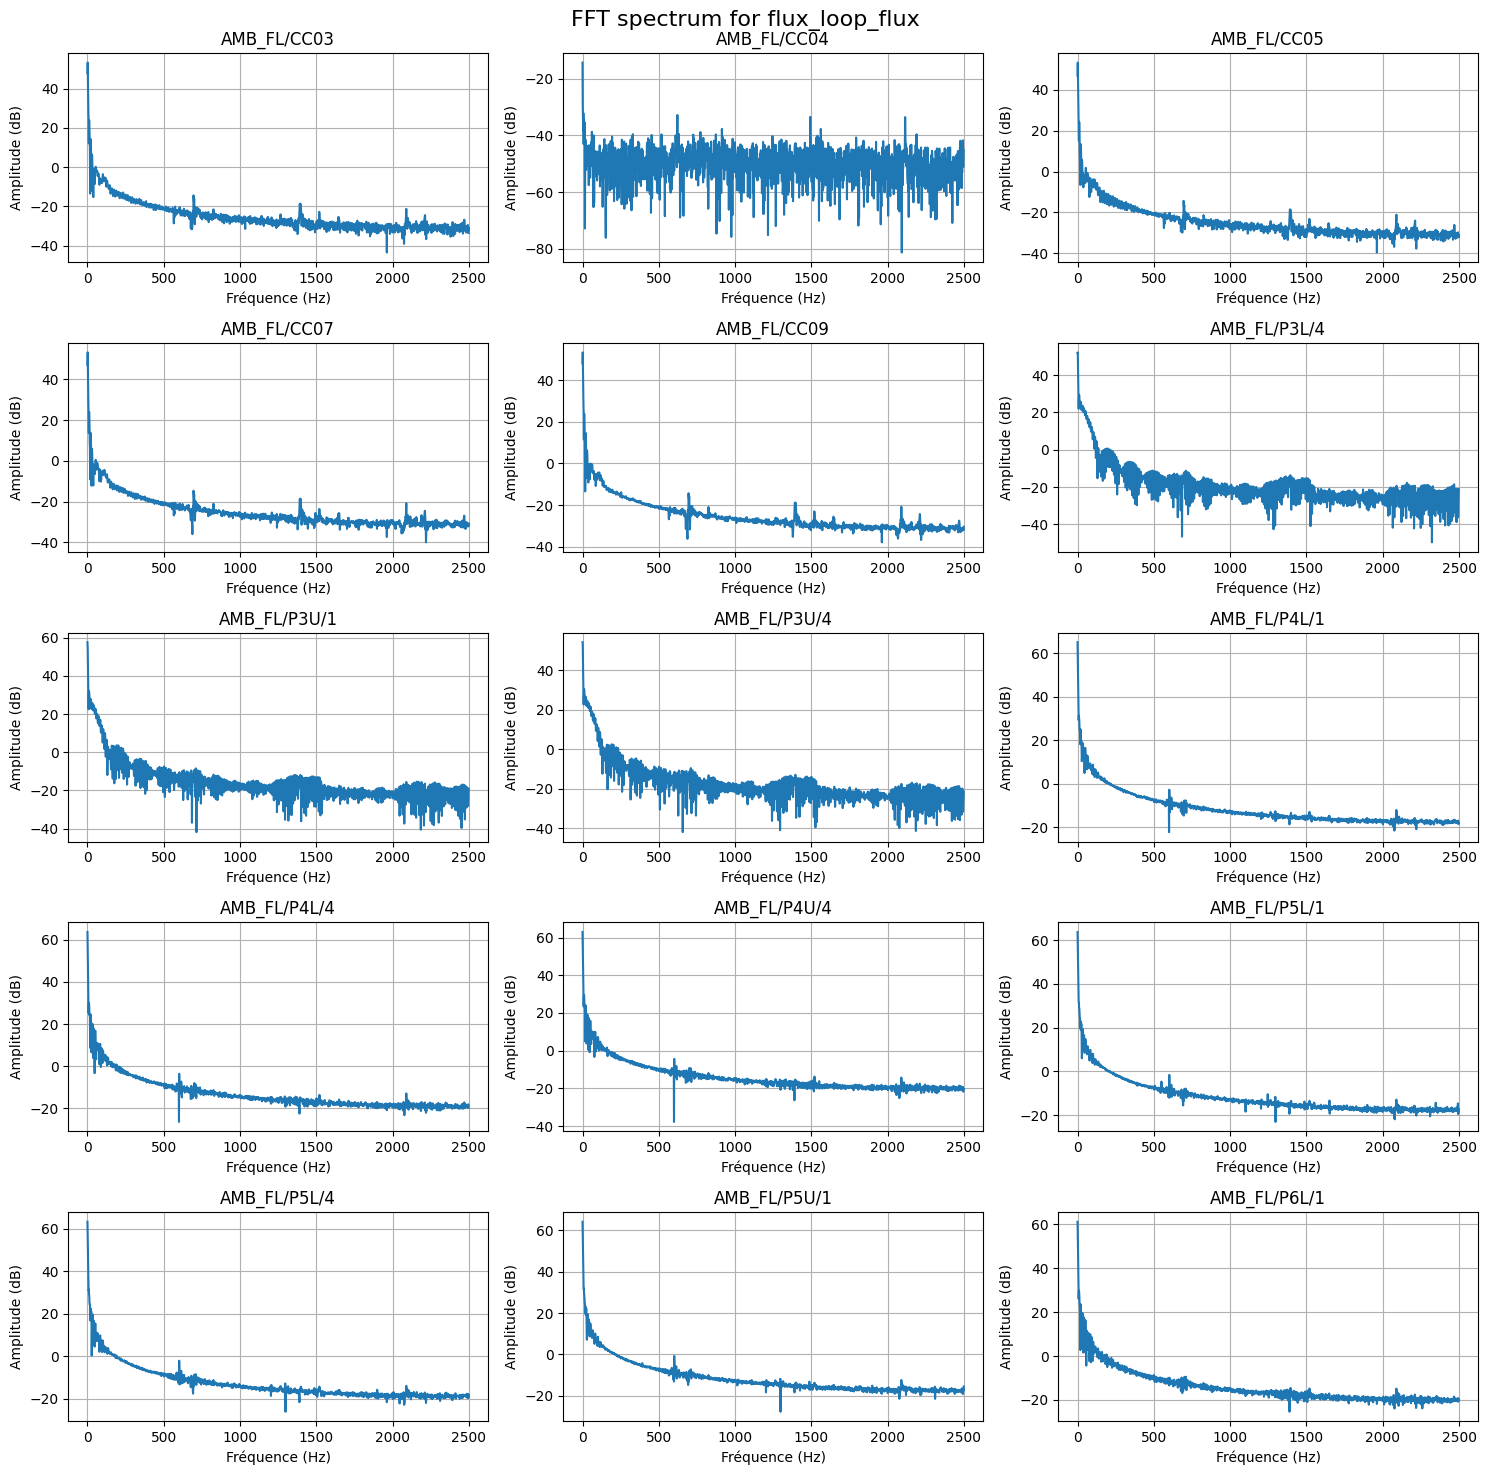

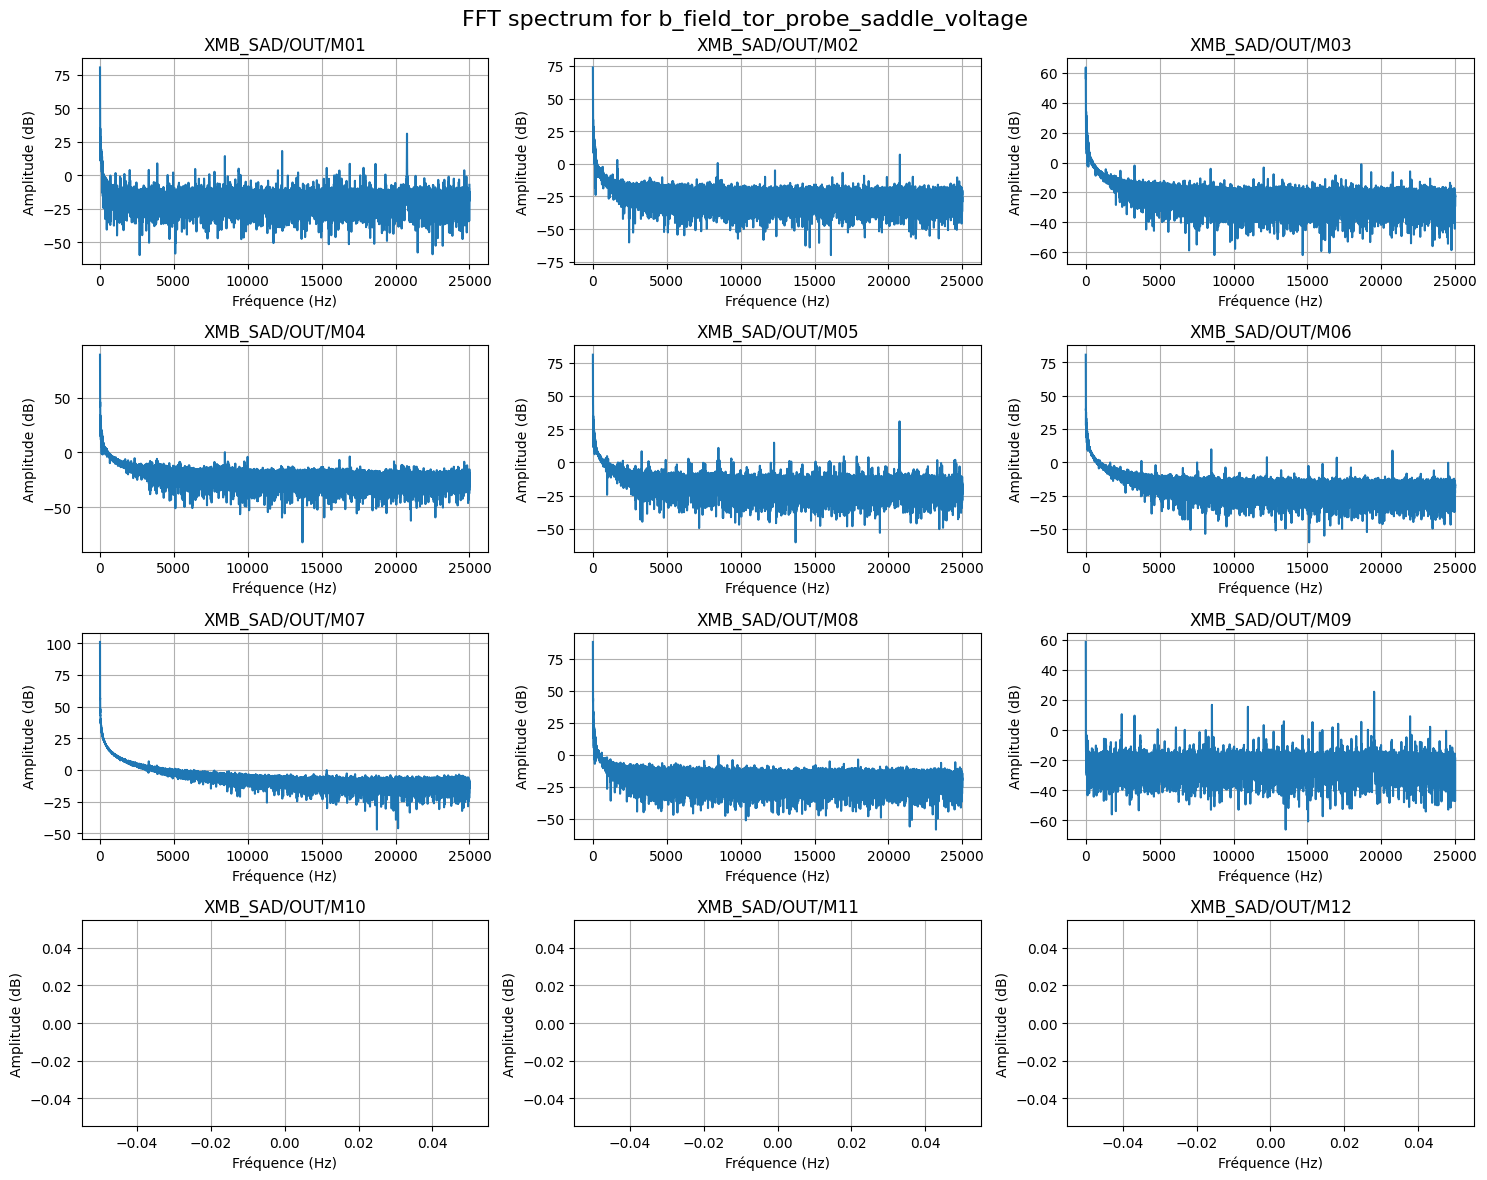

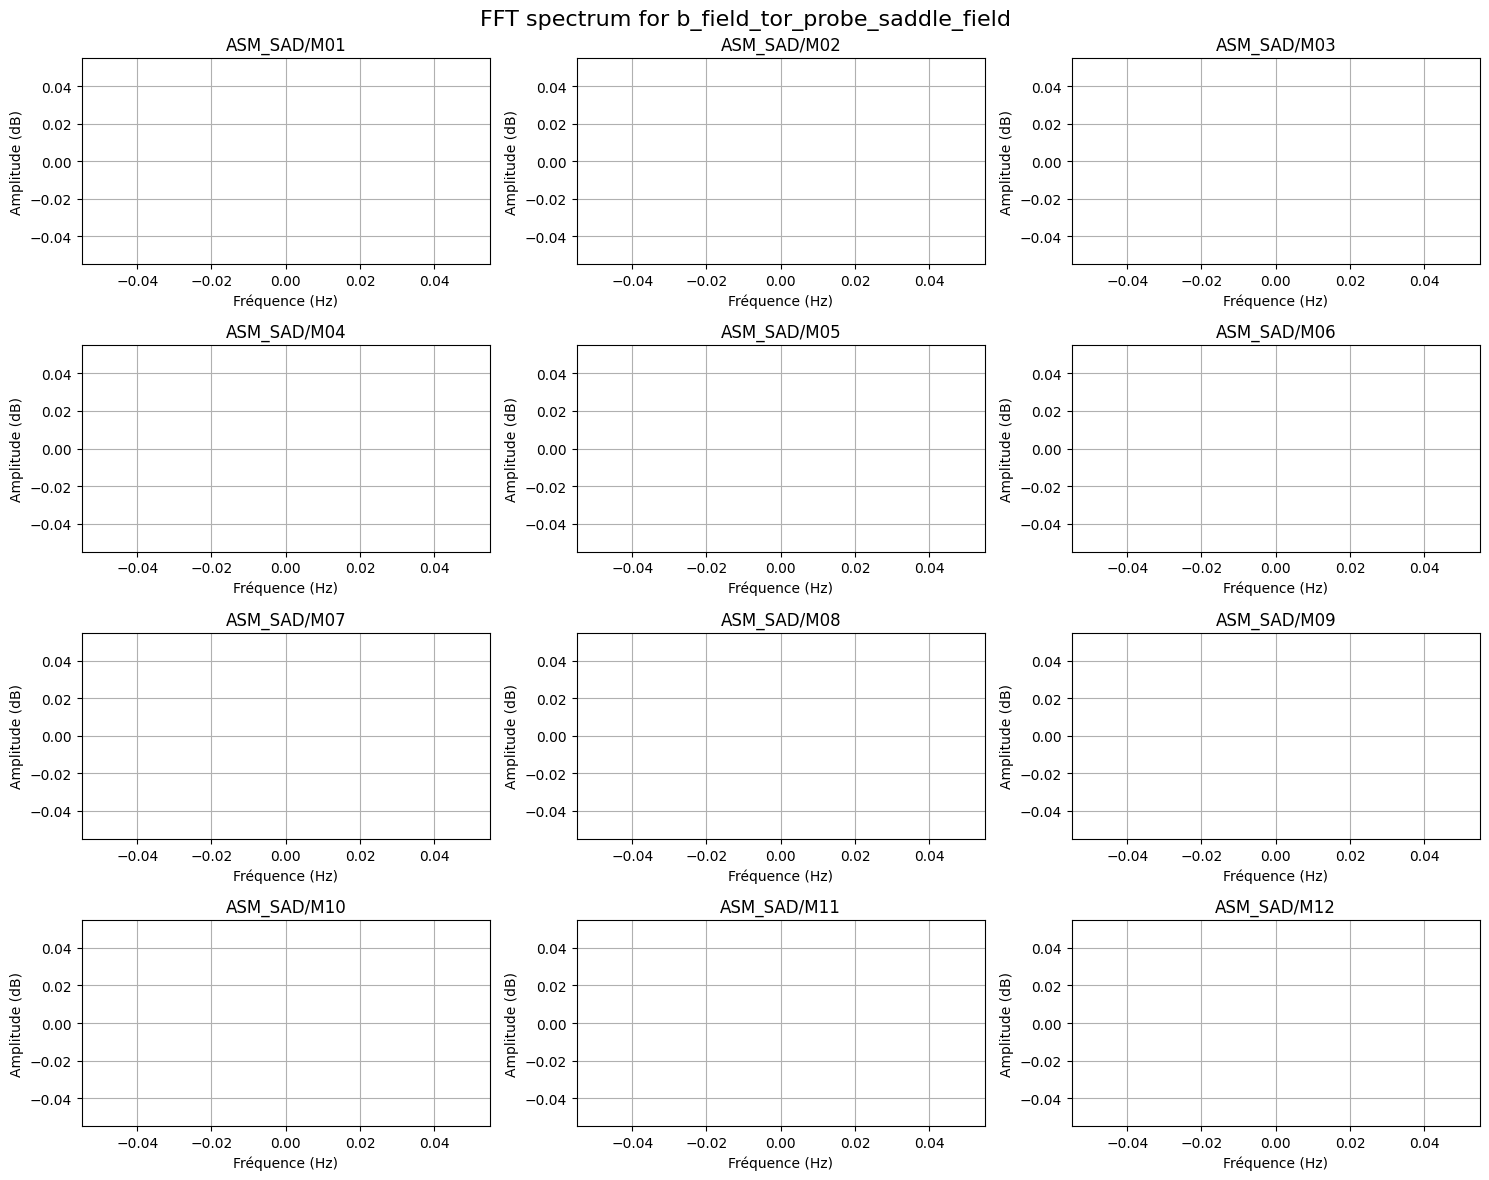

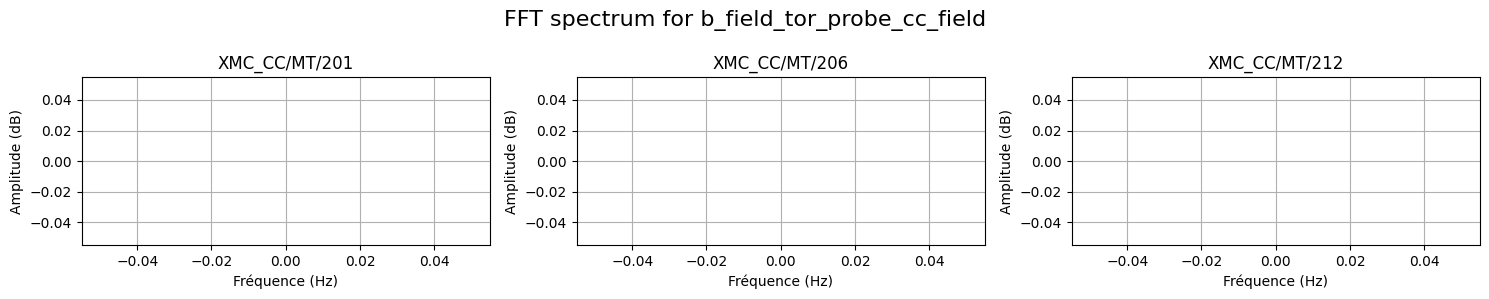

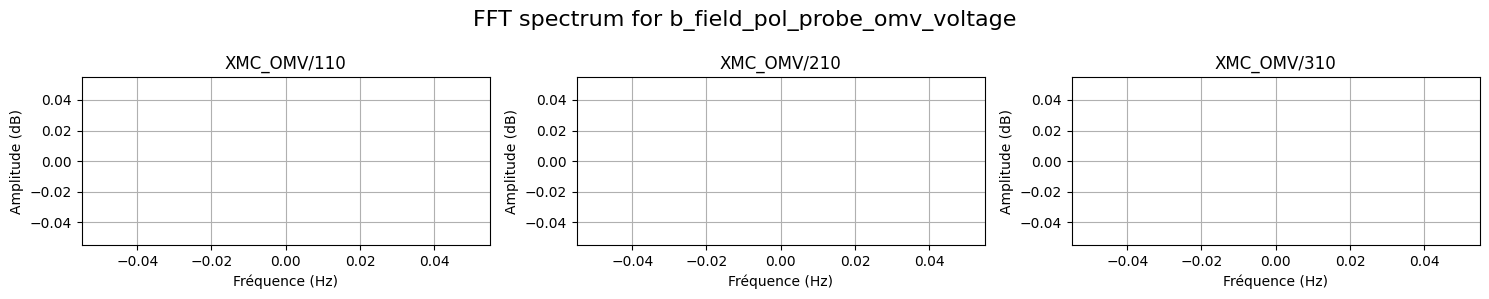

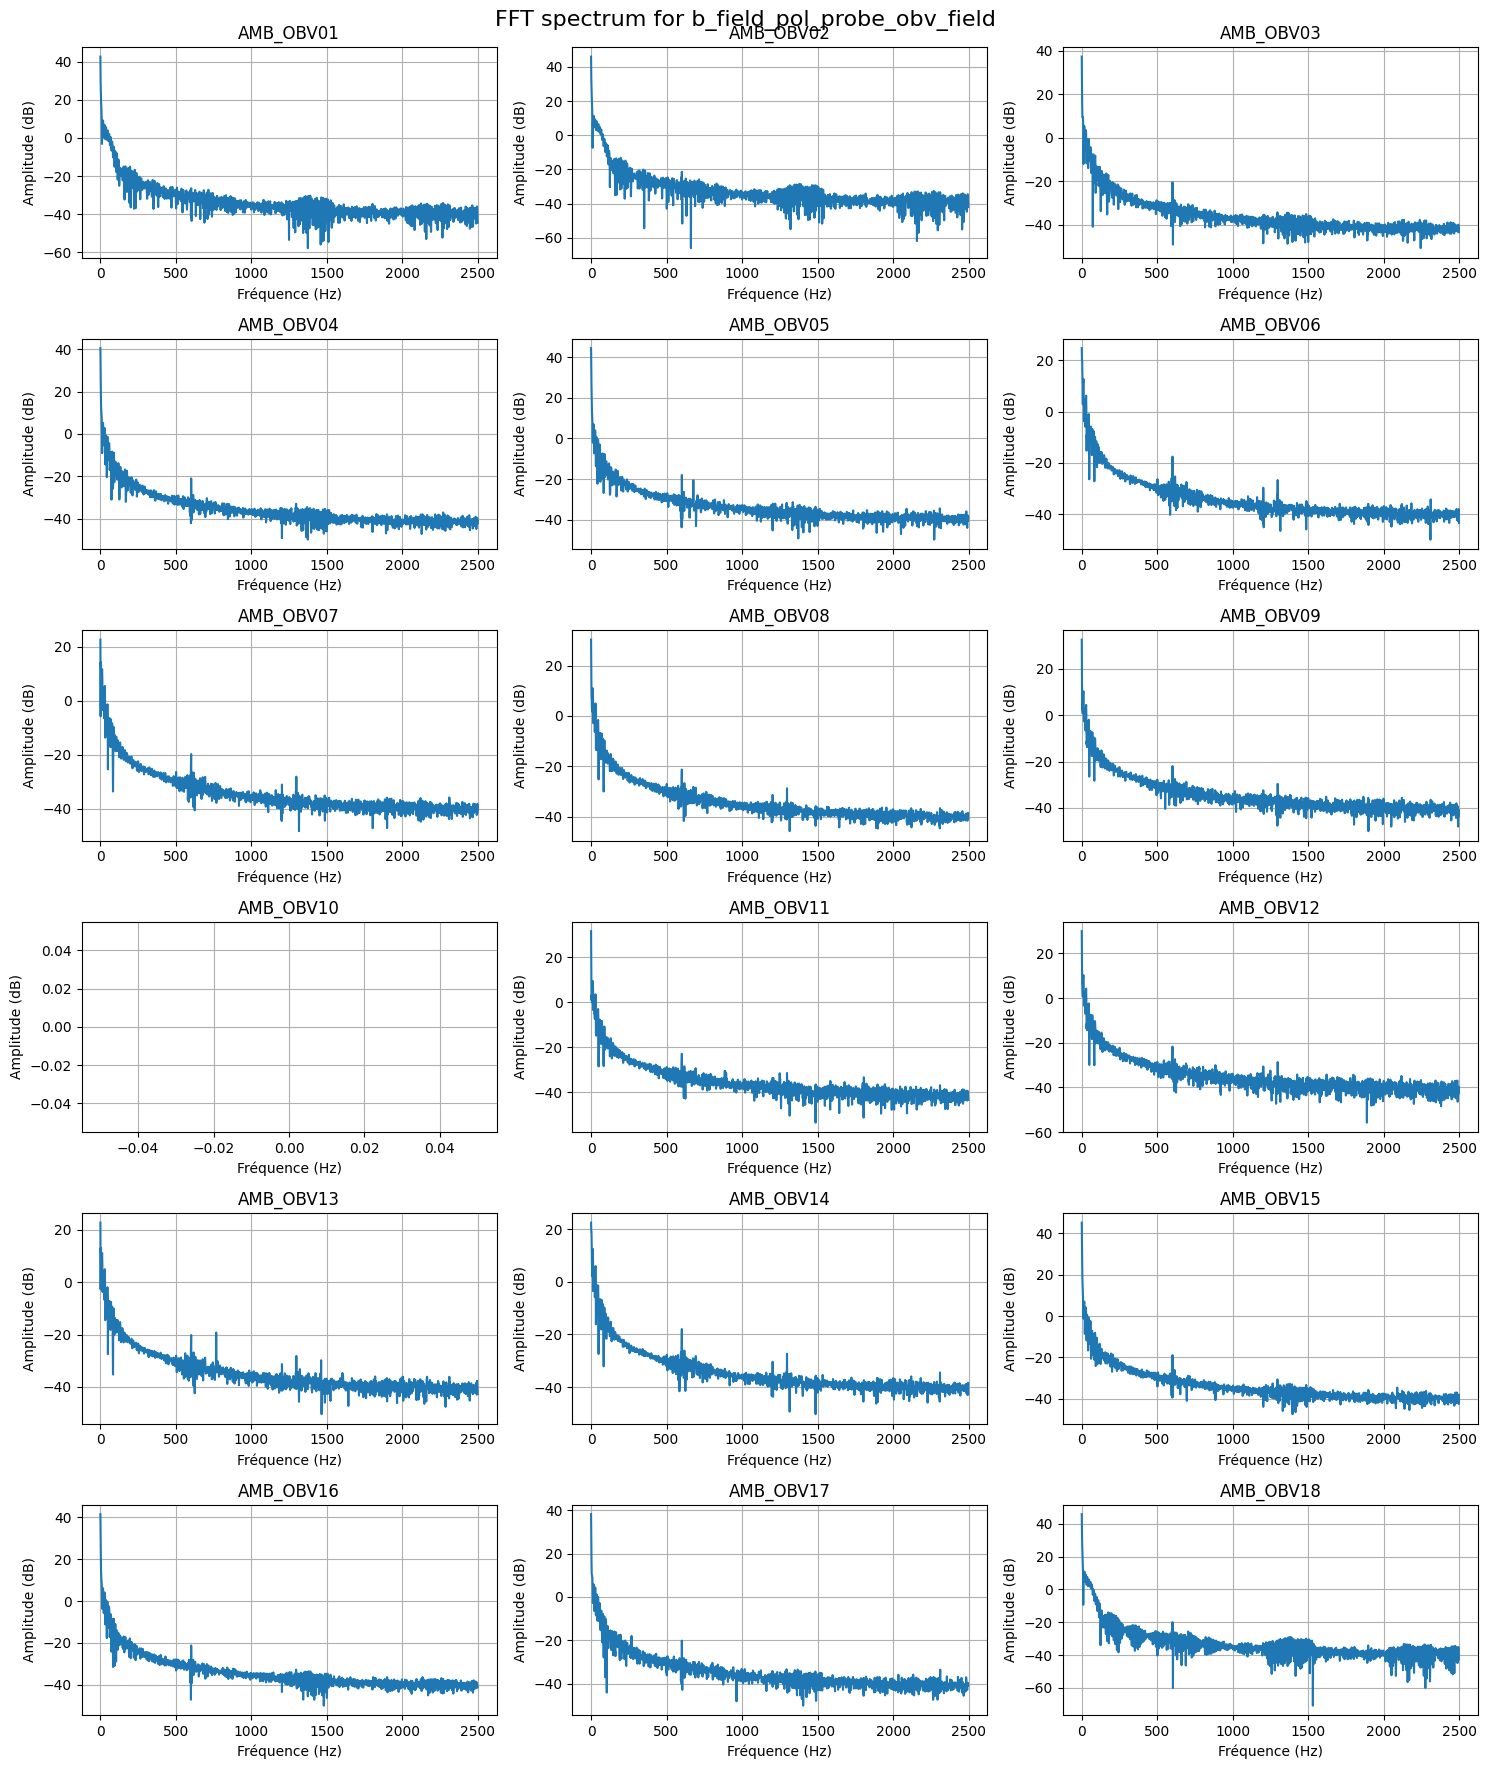

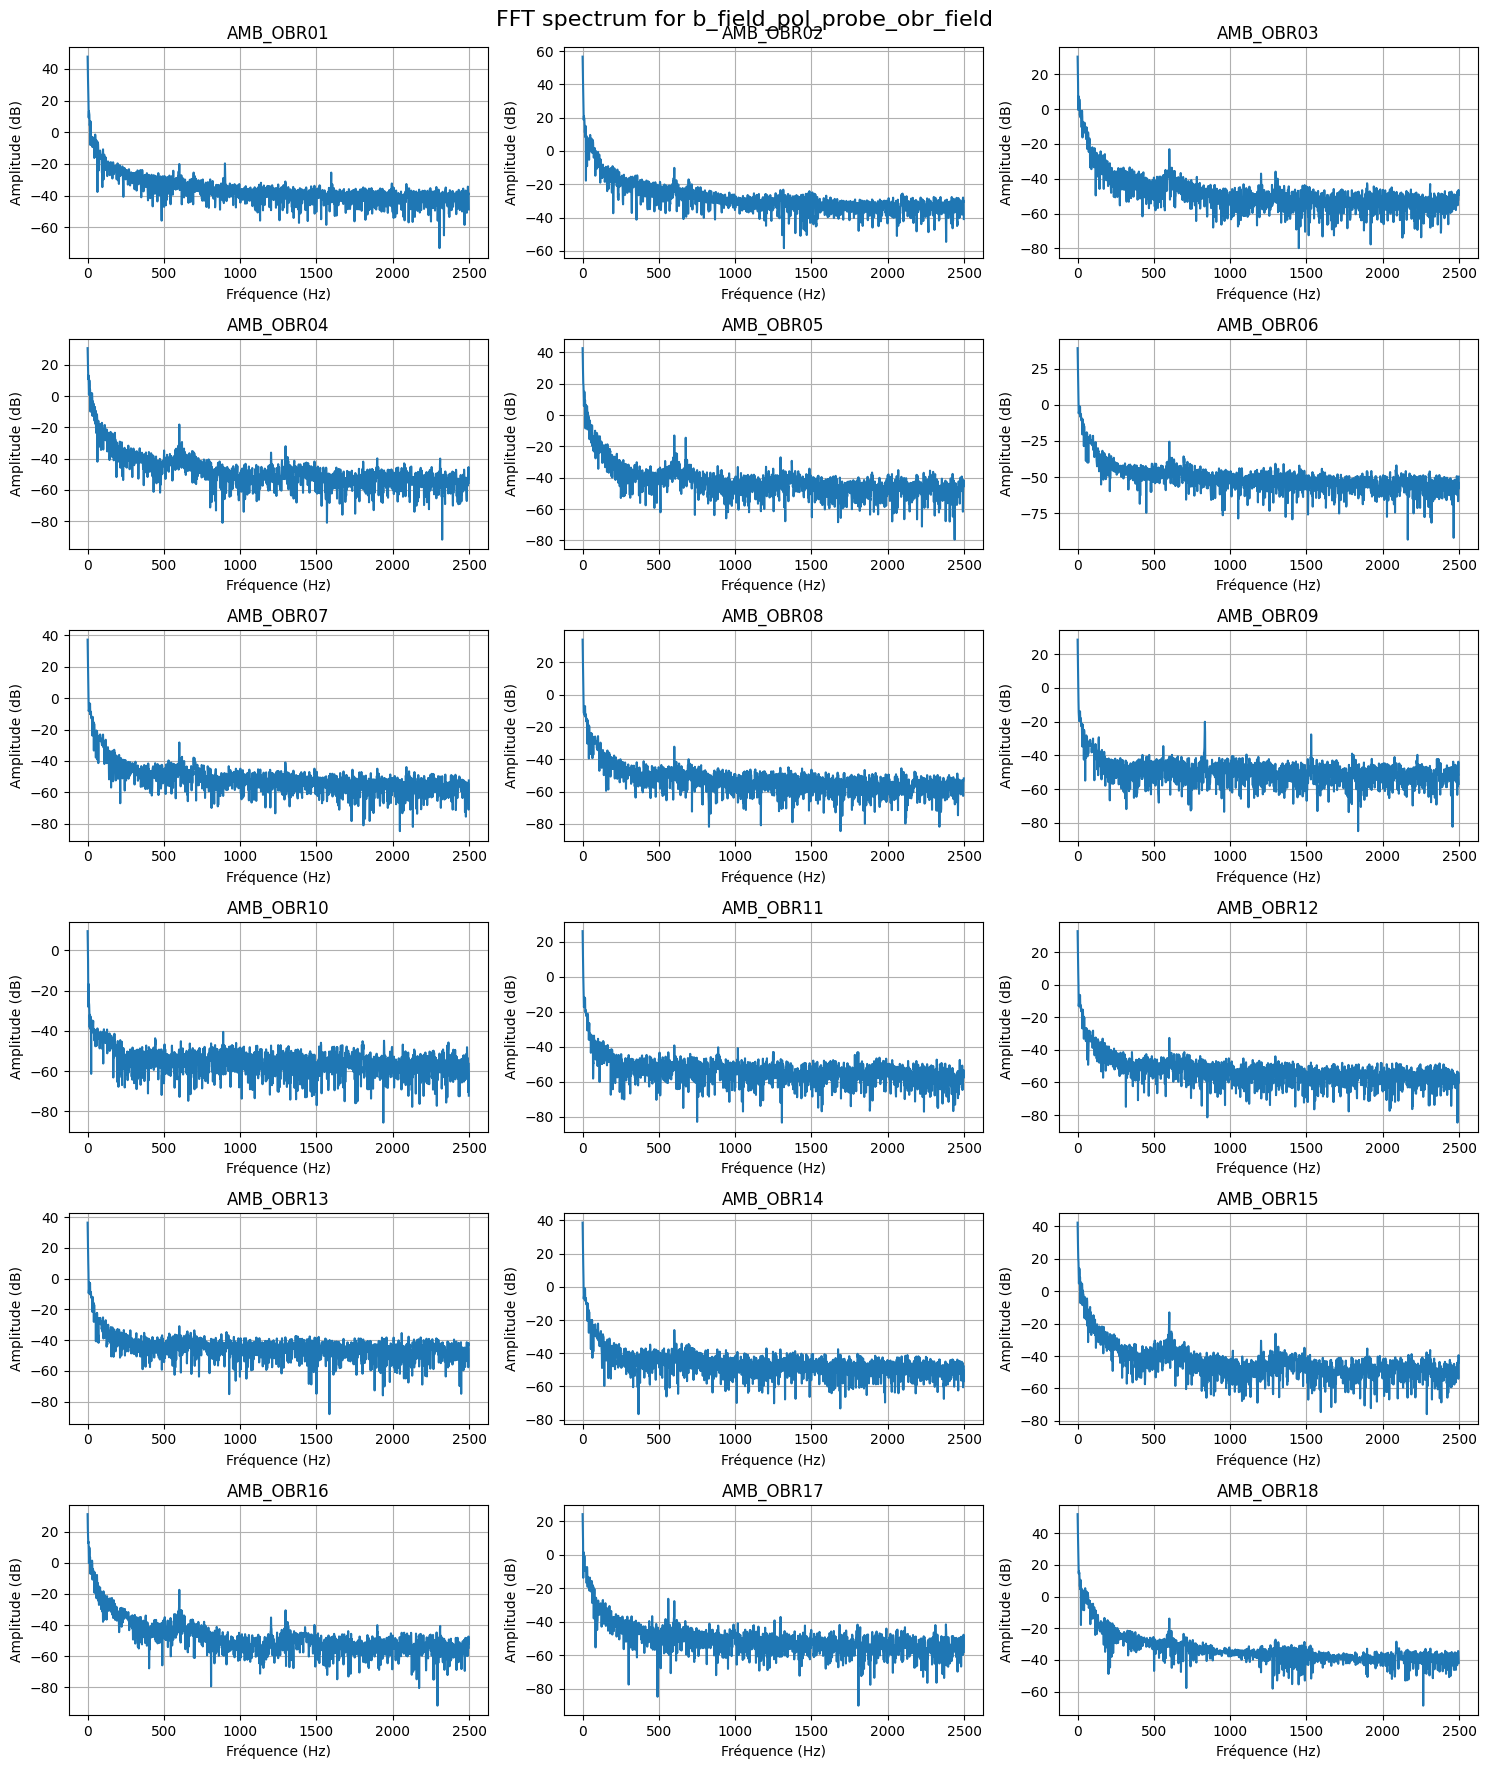

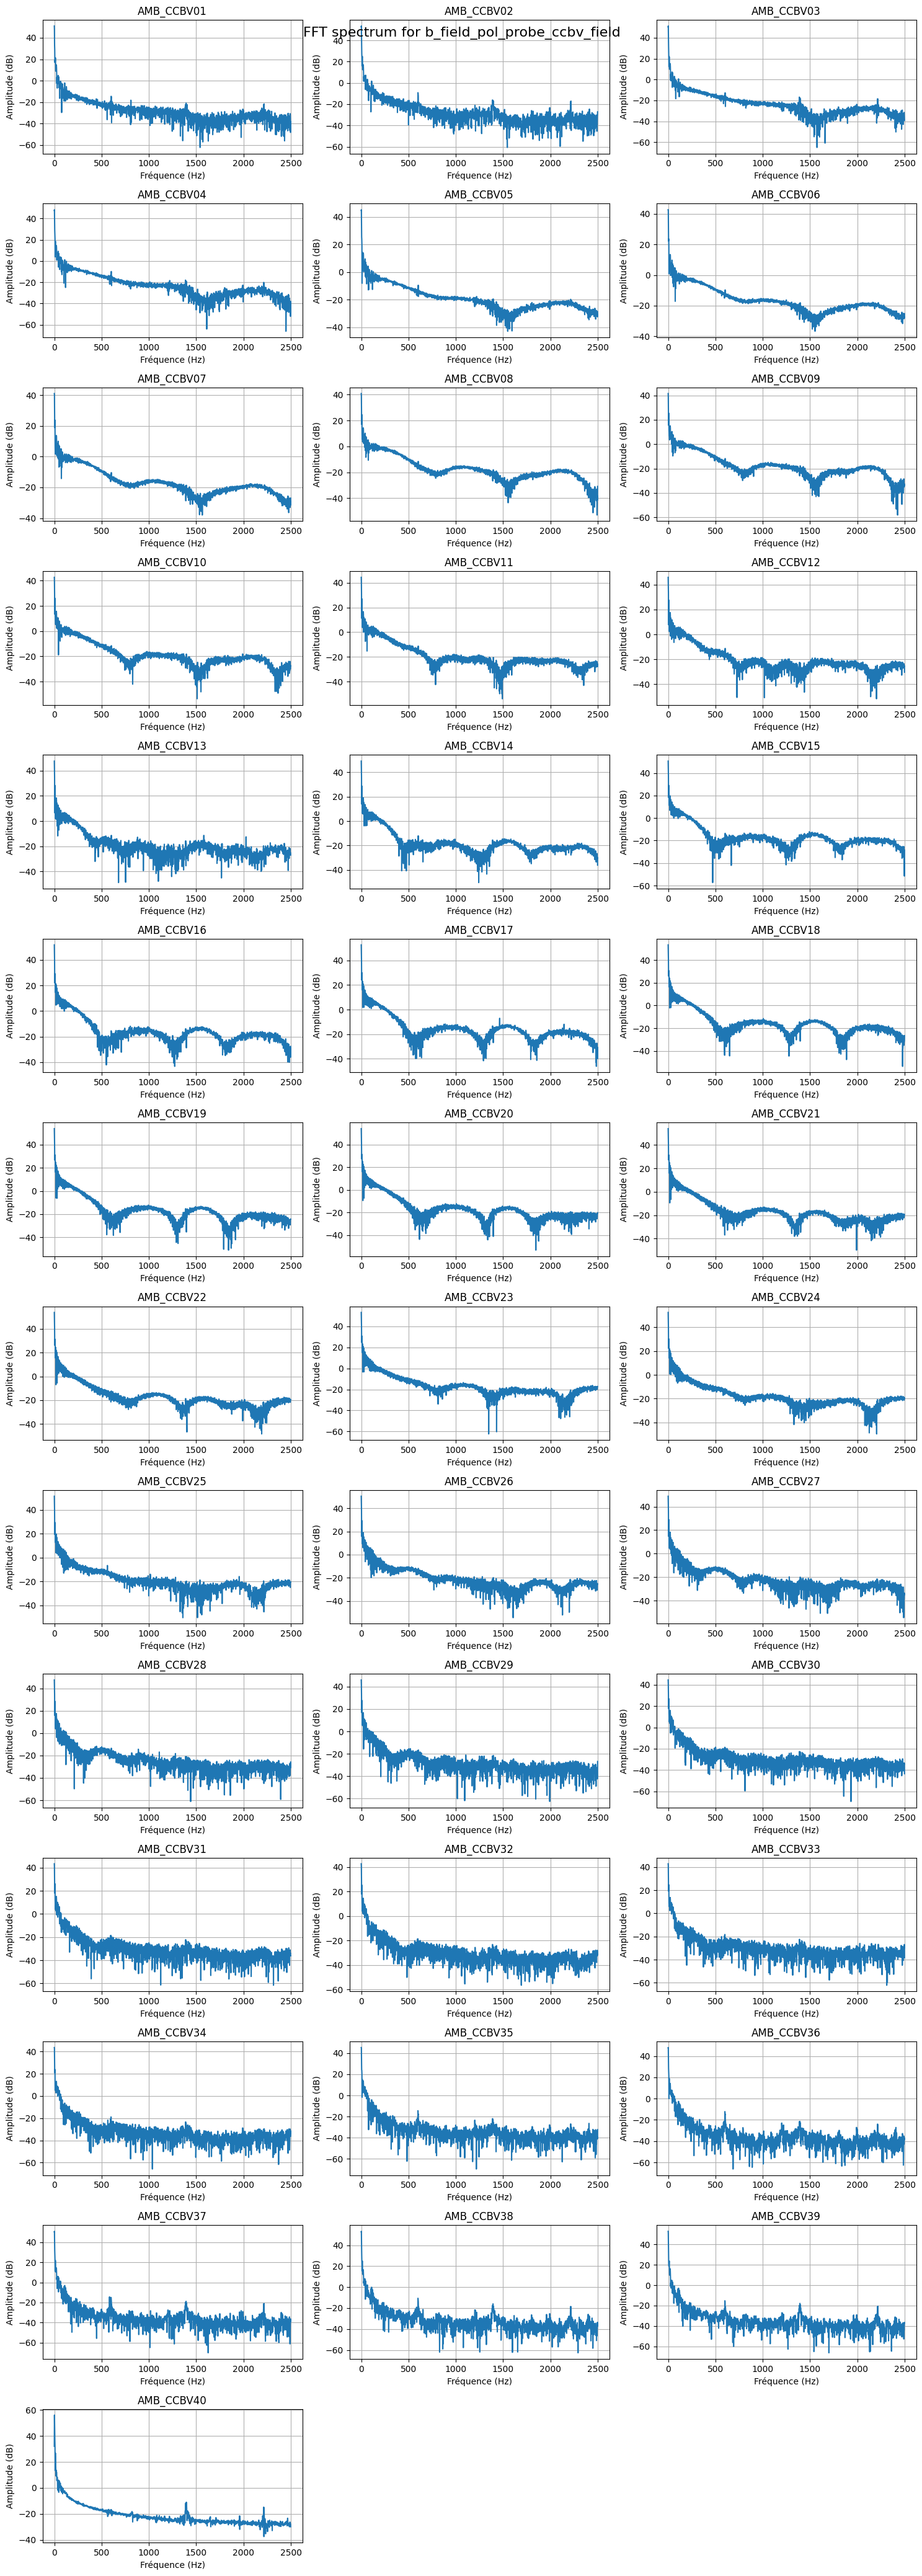

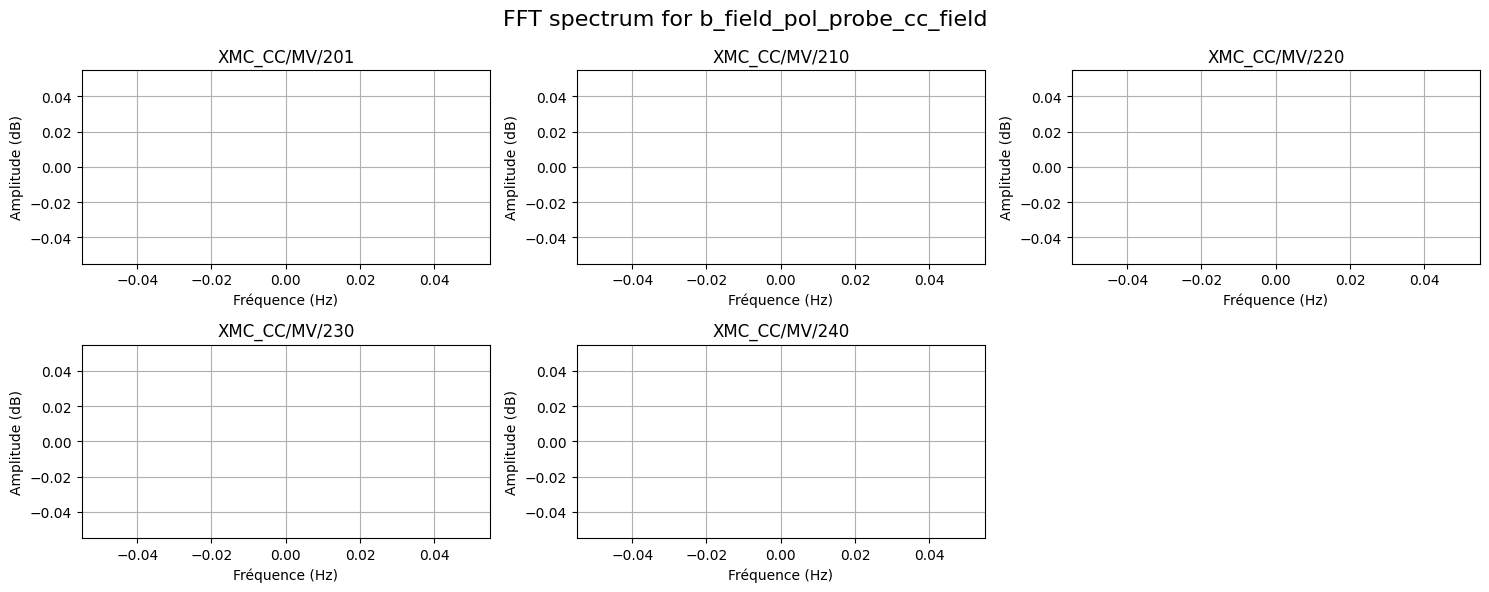

In [14]:
plot_fft_variable(ds, 'ip')
plot_fft_variable(ds, 'flux_loop_flux')
plot_fft_variable(ds, 'b_field_tor_probe_saddle_voltage')
plot_fft_variable(ds, 'b_field_tor_probe_saddle_field')
plot_fft_variable(ds, 'b_field_tor_probe_cc_field')
plot_fft_variable(ds, 'b_field_pol_probe_omv_voltage')
plot_fft_variable(ds, 'b_field_pol_probe_obv_field')
plot_fft_variable(ds, 'b_field_pol_probe_obr_field')
plot_fft_variable(ds, 'b_field_pol_probe_ccbv_field')
plot_fft_variable(ds, 'b_field_pol_probe_cc_field')


### 2. Same but for a set of shot, doing the mean of all FFTs

* We hope that the noise will cancel out.
* We will use the numpy function `np.nanmean()` to ignore NaN values.

In [5]:
def plot_mean_fft_variable(list_shot: list[int], chosen_var: str, save: bool = False):
    all_fft_db = []
    freqs_common = None
    channel_names = None
    
    for shot_index in tqdm(list_shot, desc="Processing shots"):
        try:
            ds = to_dask(shot_index, group="magnetics", level=2)
        except Exception as e:
            print(f"Error converting dataset to dask: {e}")
            continue
        try:
            da = ds[chosen_var]
            
            channel_dim, time_dim = None, None
            for dim in da.dims:
                if 'channel' in dim:
                    channel_dim = dim
                elif 'time' in dim:
                    time_dim = dim
            if time_dim is None:
                print("No time dimension found in the variable.")
                continue
                
            time_values = da[time_dim].values
            Fs = 1 / np.mean(np.diff(time_values))  # Sampling frequency

            # First shot: initialize structures
            if channel_names is None:
                if channel_dim is not None:
                    channel_names = da[channel_dim].values
                    n_chan = da.sizes[channel_dim]
                else:
                    channel_names = [chosen_var]
                    n_chan = 1
            
            shot_fft_db = []
            if channel_dim is not None:
                for i in range(n_chan):
                    channel_data = da.isel({channel_dim: i}).values
                    
                    if np.any(np.isnan(channel_data)):
                        valid_data = channel_data[~np.isnan(channel_data)]
                        if len(valid_data) == 0:
                            shot_fft_db.append(np.full(len(time_values)//2, np.nan))
                            continue
                        channel_data = np.interp(
                            np.arange(len(channel_data)), 
                            np.arange(len(channel_data))[~np.isnan(channel_data)], 
                            valid_data
                        )
                    
                    # Compute FFT
                    fft_result = np.fft.fft(channel_data)
                    freqs = np.fft.fftfreq(len(channel_data), 1/Fs)
                    n_half = len(freqs) // 2
                    positive_freqs = freqs[:n_half]
                    magnitude = np.abs(fft_result[:n_half])
                    magnitude_db = 20 * np.log10(magnitude + 1e-10)  # dB scale
                    shot_fft_db.append(magnitude_db)
                    
                    if freqs_common is None and not np.any(np.isnan(magnitude_db)):
                        freqs_common = positive_freqs
            else:
                # Case where there is no channel dimension
                channel_data = da.values
                if np.any(np.isnan(channel_data)):
                    valid_data = channel_data[~np.isnan(channel_data)]
                    if len(valid_data) == 0:
                        shot_fft_db.append(np.full(len(time_values)//2, np.nan))
                    else:
                        channel_data = np.interp(
                            np.arange(len(channel_data)), 
                            np.arange(len(channel_data))[~np.isnan(channel_data)], 
                            valid_data
                        )
                fft_result = np.fft.fft(channel_data)
                freqs = np.fft.fftfreq(len(channel_data), 1/Fs)
                n_half = len(freqs) // 2
                positive_freqs = freqs[:n_half]
                magnitude = np.abs(fft_result[:n_half])
                magnitude_db = 20 * np.log10(magnitude + 1e-10)
                shot_fft_db.append(magnitude_db)
                if freqs_common is None:
                    freqs_common = positive_freqs


            shot_fft_db = np.atleast_2d(shot_fft_db)
            all_fft_db.append(shot_fft_db)
            
            if freqs_common is None:
                n_half = len(positive_freqs)
                freqs_common = positive_freqs
    
        except Exception as e:
            print(f"Error during processing shot {shot_index}: {e}")
            continue
    
    if len(all_fft_db) == 0:
        print("No valid data found")
        return
    
    min_len = min(fft.shape[1] for fft in all_fft_db)
    freqs_common = freqs_common[:min_len]
    
    # Tronquer toutes les FFT à la longueur minimale
    all_fft_db = [fft[:, :min_len] for fft in all_fft_db]
    
    # Combiner tous les shots en un seul tableau
    all_fft_db = np.vstack(all_fft_db)  # Forme (n_shots * n_chan, min_len)
    
    # Calculer la moyenne pour chaque canal
    n_chan = len(channel_names)
    mean_fft_db = []
    for i in range(n_chan):
        channel_fft = all_fft_db[i::n_chan]  # Sélectionner tous les shots pour ce canal
        mean_fft_db.append(np.nanmean(channel_fft, axis=0))
    
    # Plot part
    n_chan = len(mean_fft_db)

    if n_chan == 1:
        # Cas single channel
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.plot(freqs_common, mean_fft_db[0])
        ax.set_title(f'FFT mean for {chosen_var} ({len(list_shot)} shots)', fontsize=16)
        ax.set_xlabel('Frequency (Hz)')
        ax.set_ylabel('Amplitude (dB)')
        ax.grid(True)
    else:
        # Case multi-channel
        n_rows = (n_chan + 2) // 3
        fig, axs = plt.subplots(n_rows, 3, figsize=(15, 3 * n_rows))
        axs = axs.flatten()
        
        for i in range(n_chan):
            axs[i].plot(freqs_common, mean_fft_db[i])
            axs[i].set_title(f'{channel_names[i]}')
            axs[i].set_xlabel('Fréquence (Hz)')
            axs[i].set_ylabel('Amplitude (dB)')
            axs[i].grid(True)
        for j in range(n_chan, len(axs)):
            axs[j].set_visible(False)

        plt.suptitle(f'FFT mean for {chosen_var} ({len(list_shot)} shots)', fontsize=16)

    plt.tight_layout()
    if save:
        path = Path().absolute().parent / "result_files/spectral_signatures" / f"{chosen_var}_mean_fft.png"
        plt.savefig(path, dpi=900)

    plt.show()
    
    return mean_fft_db, freqs_common, channel_names

In [6]:
path = Path().absolute().parent / "result_files/nan_stats_magnetics/result_lists_magnetics_nans.json"
print(path)
with open(path, 'r') as f:
    data = json.load(f)
list_shot_all = data["good_shot_ids"]

list_shot_all

/home/ITER/brussel/Documents/ITER-magnetics-diagnostic-analysis/notebooks/result_files/nan_stats_magnetics/result_lists_magnetics_nans.json


['12378',
 '12379',
 '12382',
 '12385',
 '12386',
 '12387',
 '12388',
 '12390',
 '12391',
 '12397',
 '12398',
 '12399',
 '12400',
 '12401',
 '12403',
 '12406',
 '12408',
 '12409',
 '12410',
 '12411',
 '12412',
 '12413',
 '12414',
 '12415',
 '12416',
 '12417',
 '12418',
 '12421',
 '12422',
 '12426',
 '12427',
 '12428',
 '12429',
 '12430',
 '12431',
 '12432',
 '12433',
 '12434',
 '12435',
 '12436',
 '12437',
 '12438',
 '12439',
 '12440',
 '12441',
 '12442',
 '12444',
 '12445',
 '12446',
 '12447',
 '12448',
 '12449',
 '12450',
 '12451',
 '12455',
 '12456',
 '12457',
 '12458',
 '12460',
 '12461',
 '12462',
 '12463',
 '12465',
 '12466',
 '12467',
 '12468',
 '12469',
 '12470',
 '12471',
 '12472',
 '12473',
 '12474',
 '12475',
 '12476',
 '12477',
 '12478',
 '12479',
 '12480',
 '12481',
 '12482',
 '12483',
 '12484',
 '12485',
 '12487',
 '12488',
 '12489',
 '12490',
 '12493',
 '12494',
 '12497',
 '12498',
 '12499',
 '12500',
 '12501',
 '12503',
 '12505',
 '12506',
 '12507',
 '12508',
 '12509',


In [7]:
list_shot = np.random.choice(list_shot_all, size=100, replace=False)

Processing shots: 100%|██████████| 100/100 [03:12<00:00,  1.92s/it]


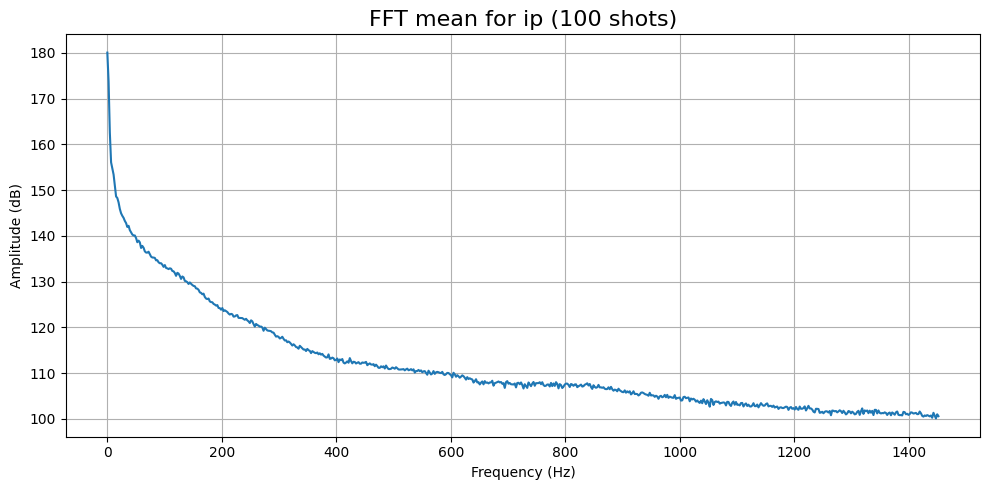

Processing shots: 100%|██████████| 100/100 [04:11<00:00,  2.51s/it]


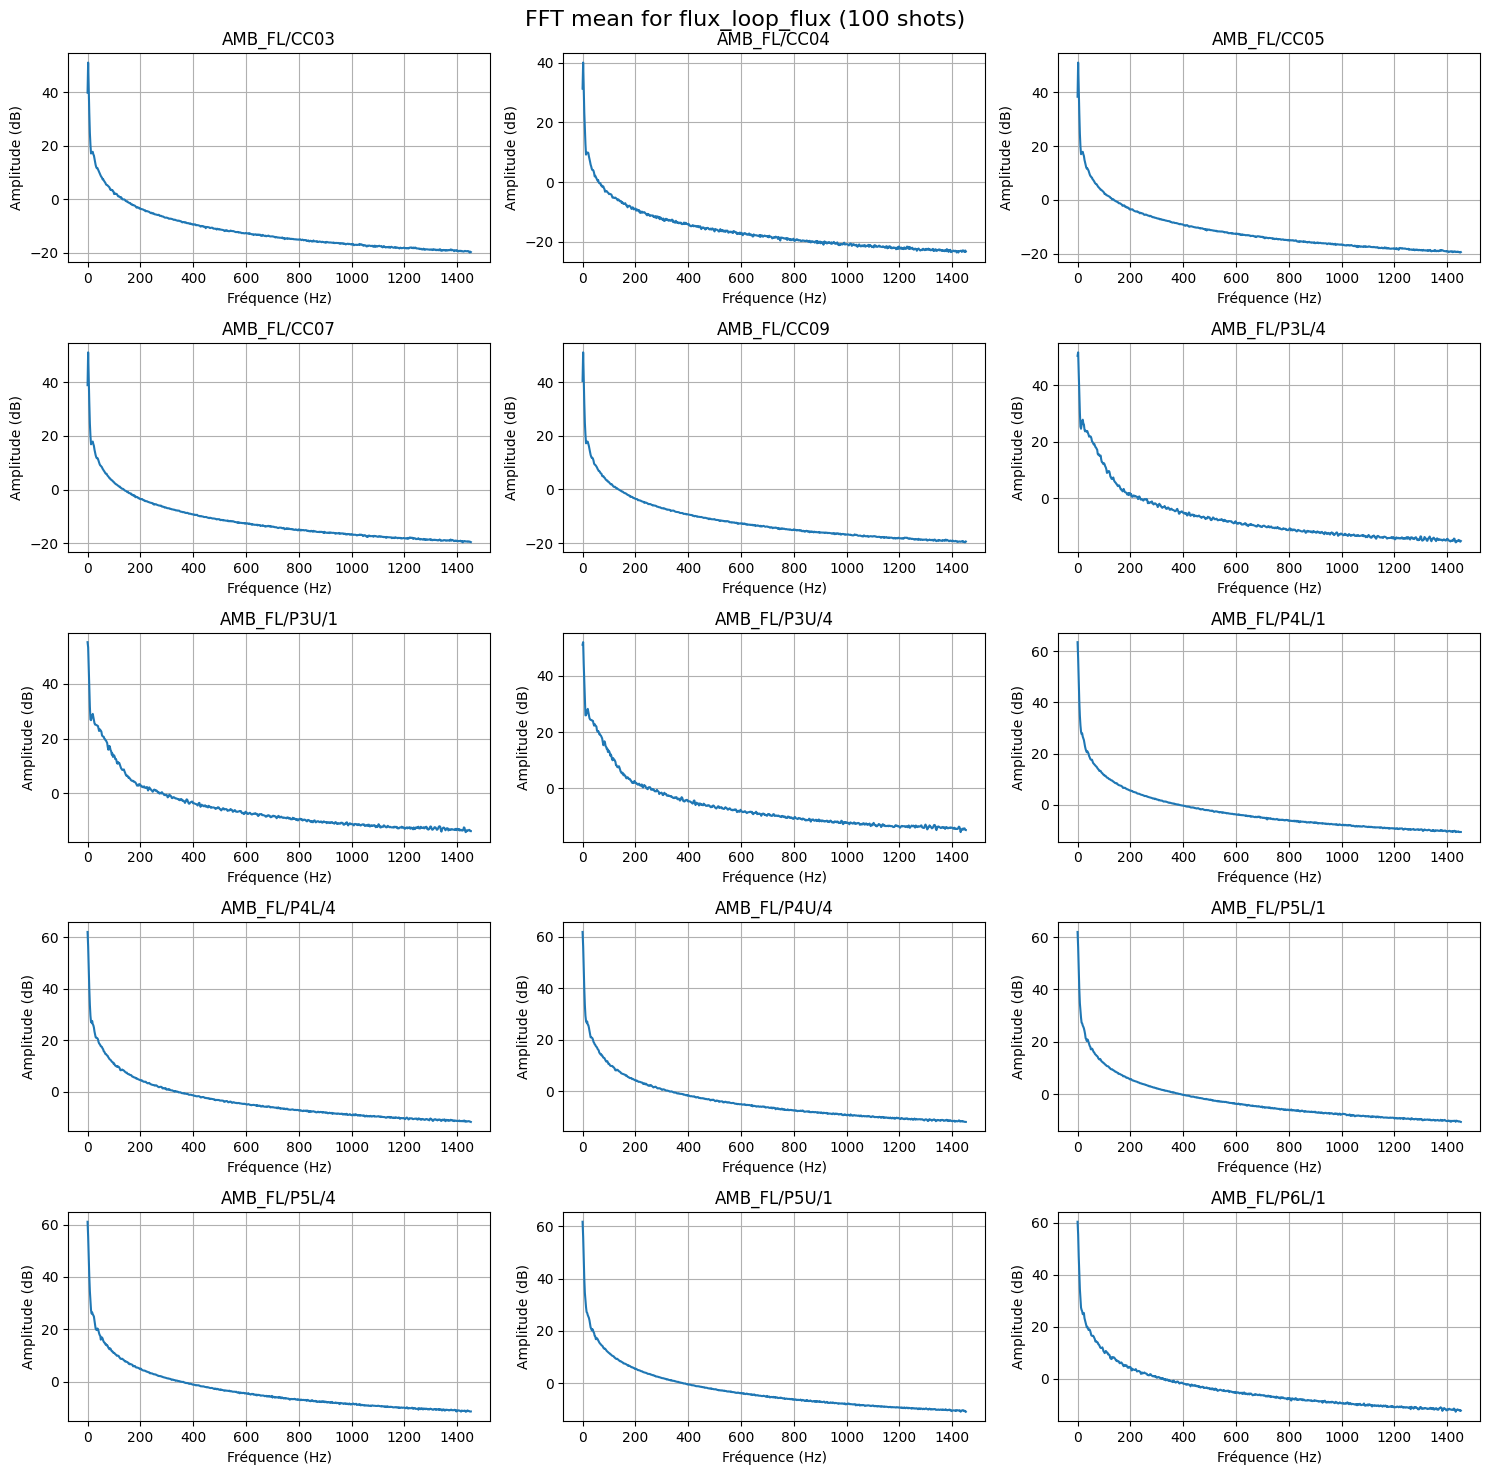

Processing shots: 100%|██████████| 100/100 [04:08<00:00,  2.48s/it]
/tmp/ipykernel_2835299/2873808131.py:117: RuntimeWarning: Mean of empty slice
  mean_fft_db.append(np.nanmean(channel_fft, axis=0))


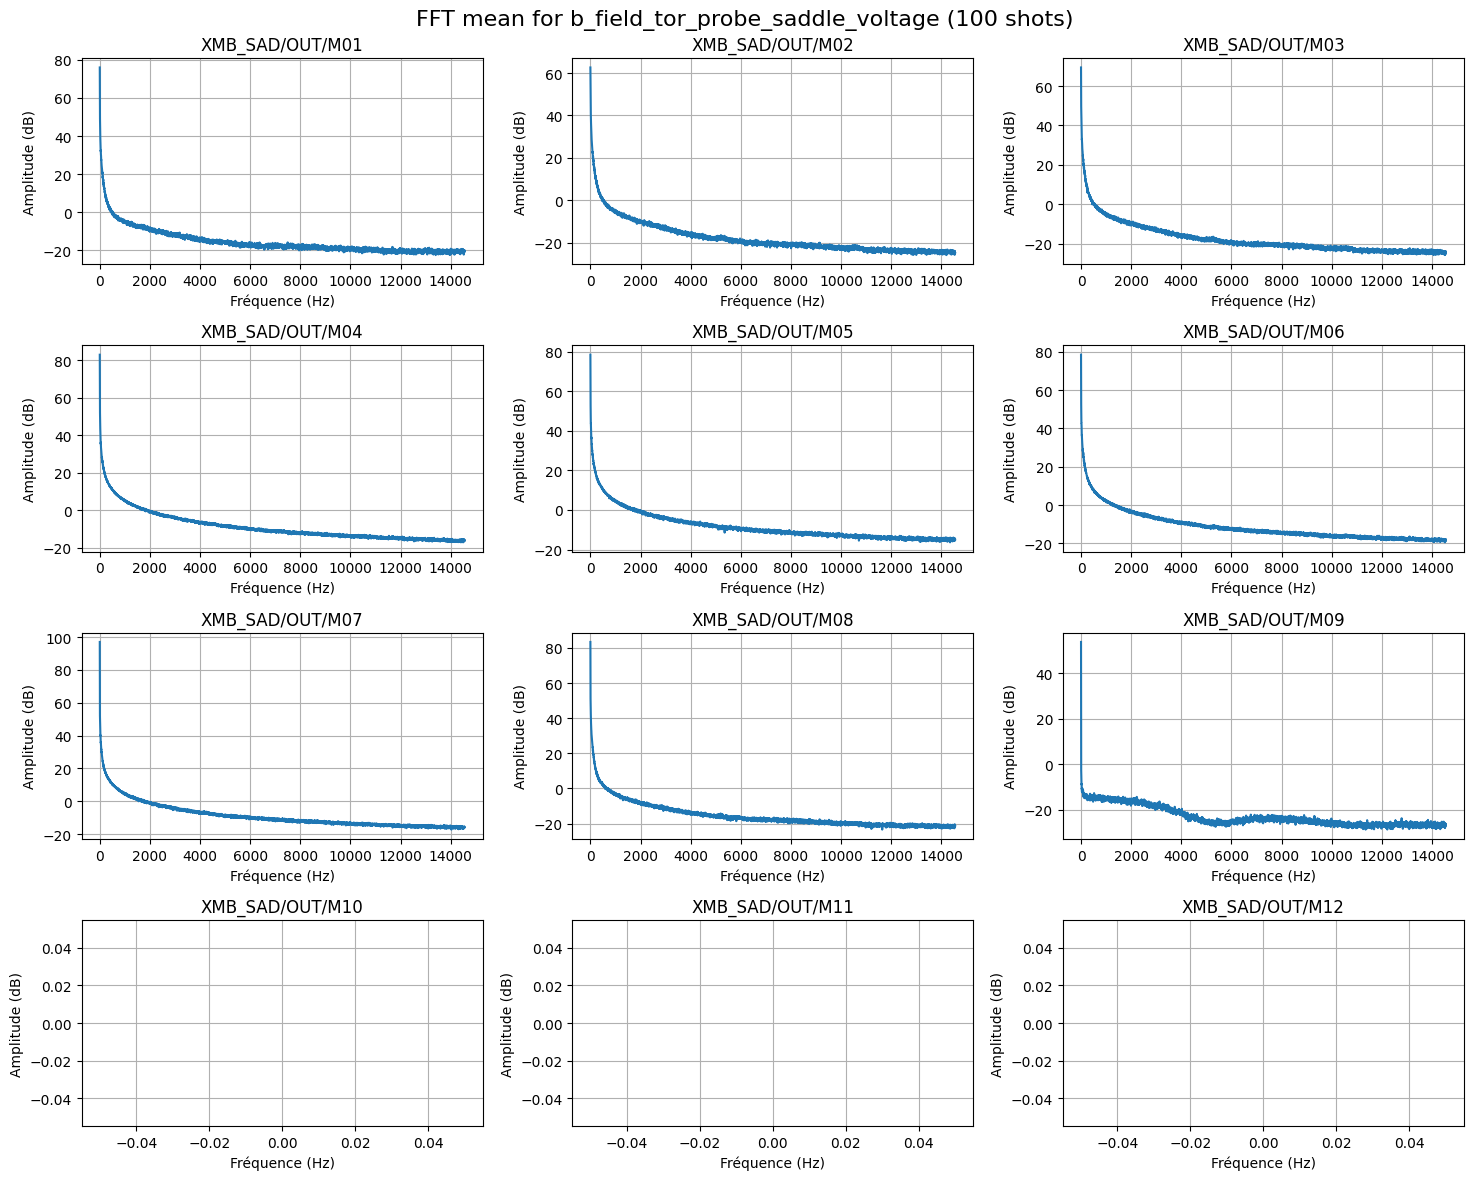

Processing shots: 100%|██████████| 100/100 [04:00<00:00,  2.41s/it]
/tmp/ipykernel_2835299/2873808131.py:117: RuntimeWarning: Mean of empty slice
  mean_fft_db.append(np.nanmean(channel_fft, axis=0))


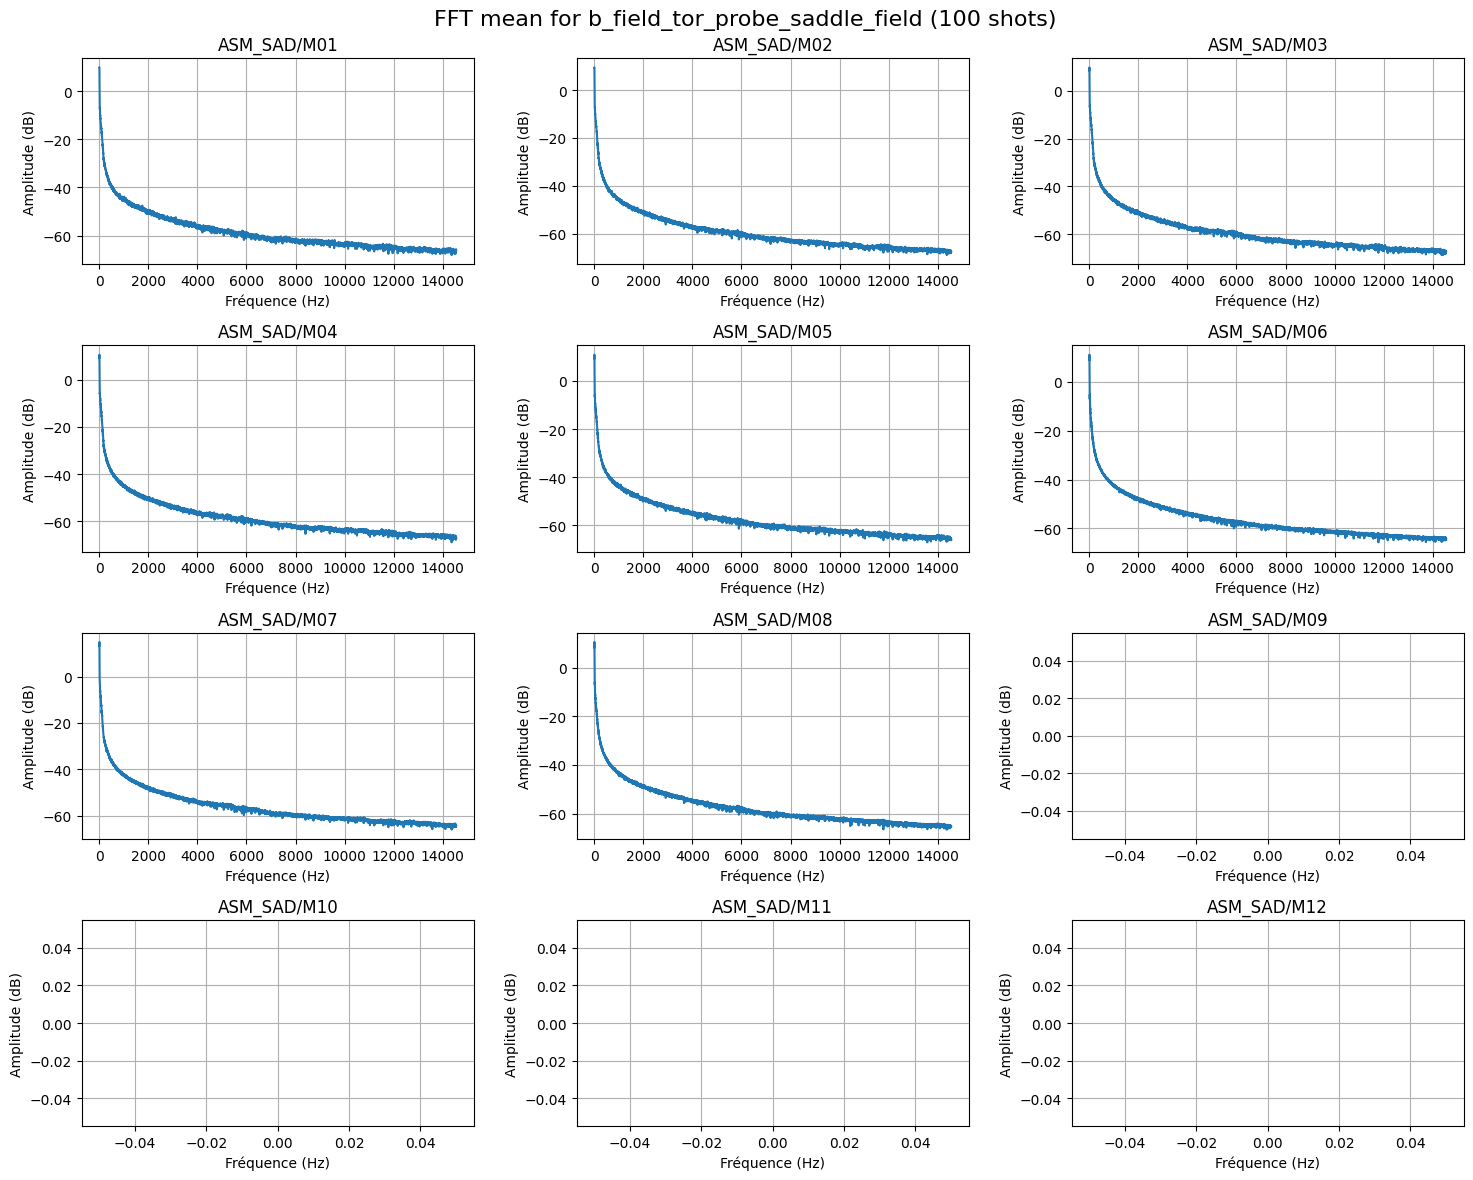

Processing shots:   1%|          | 1/100 [00:01<02:00,  1.21s/it]

Error during processing shot 15119: "No variable named 'b_field_tor_probe_cc_field'. Did you mean one of ('b_field_pol_probe_cc_field', 'b_field_pol_probe_ccbv_field', 'b_field_tor_probe_saddle_field', 'b_field_pol_probe_obv_field', 'b_field_pol_probe_obr_field', 'b_field_pol_probe_cc_channel', 'b_field_tor_probe_saddle_field_channel', 'b_field_pol_probe_ccbv_channel', 'b_field_pol_probe_omv_channel', 'b_field_pol_probe_obv_channel')?"


Processing shots:   2%|▏         | 2/100 [00:02<01:51,  1.14s/it]

Error during processing shot 16455: "No variable named 'b_field_tor_probe_cc_field'. Did you mean one of ('b_field_pol_probe_cc_field', 'b_field_pol_probe_ccbv_field', 'b_field_tor_probe_saddle_field', 'b_field_pol_probe_obv_field', 'b_field_pol_probe_obr_field', 'b_field_pol_probe_cc_channel', 'b_field_tor_probe_saddle_field_channel', 'b_field_pol_probe_ccbv_channel', 'b_field_pol_probe_omv_channel', 'b_field_pol_probe_obv_channel')?"


Processing shots:   3%|▎         | 3/100 [00:03<01:42,  1.06s/it]

Error during processing shot 19919: "No variable named 'b_field_tor_probe_cc_field'. Did you mean one of ('b_field_pol_probe_cc_field', 'b_field_pol_probe_ccbv_field', 'b_field_tor_probe_saddle_field', 'b_field_pol_probe_obv_field', 'b_field_pol_probe_obr_field', 'b_field_pol_probe_cc_channel', 'b_field_tor_probe_saddle_field_channel', 'b_field_pol_probe_ccbv_channel', 'b_field_pol_probe_omv_channel', 'b_field_pol_probe_obv_channel')?"


Processing shots:   7%|▋         | 7/100 [00:09<02:13,  1.43s/it]

Error during processing shot 16278: "No variable named 'b_field_tor_probe_cc_field'. Did you mean one of ('b_field_pol_probe_cc_field', 'b_field_pol_probe_ccbv_field', 'b_field_tor_probe_saddle_field', 'b_field_pol_probe_obv_field', 'b_field_pol_probe_obr_field', 'b_field_pol_probe_cc_channel', 'b_field_tor_probe_saddle_field_channel', 'b_field_pol_probe_ccbv_channel', 'b_field_pol_probe_omv_channel', 'b_field_pol_probe_obv_channel')?"


Processing shots:  10%|█         | 10/100 [00:14<02:19,  1.55s/it]

Error during processing shot 20296: "No variable named 'b_field_tor_probe_cc_field'. Did you mean one of ('b_field_pol_probe_cc_field', 'b_field_pol_probe_ccbv_field', 'b_field_tor_probe_saddle_field', 'b_field_pol_probe_obv_field', 'b_field_pol_probe_obr_field', 'b_field_pol_probe_cc_channel', 'b_field_tor_probe_saddle_field_channel', 'b_field_pol_probe_ccbv_channel', 'b_field_pol_probe_omv_channel', 'b_field_pol_probe_obv_channel')?"


Processing shots:  14%|█▍        | 14/100 [00:22<02:30,  1.75s/it]

Error during processing shot 16134: "No variable named 'b_field_tor_probe_cc_field'. Did you mean one of ('b_field_pol_probe_cc_field', 'b_field_pol_probe_ccbv_field', 'b_field_tor_probe_saddle_field', 'b_field_pol_probe_obv_field', 'b_field_pol_probe_obr_field', 'b_field_pol_probe_cc_channel', 'b_field_tor_probe_saddle_field_channel', 'b_field_pol_probe_ccbv_channel', 'b_field_pol_probe_omv_channel', 'b_field_pol_probe_obv_channel')?"


Processing shots:  15%|█▌        | 15/100 [00:23<02:11,  1.55s/it]

Error during processing shot 20285: "No variable named 'b_field_tor_probe_cc_field'. Did you mean one of ('b_field_pol_probe_cc_field', 'b_field_pol_probe_ccbv_field', 'b_field_tor_probe_saddle_field', 'b_field_pol_probe_obv_field', 'b_field_pol_probe_obr_field', 'b_field_pol_probe_cc_channel', 'b_field_tor_probe_saddle_field_channel', 'b_field_pol_probe_ccbv_channel', 'b_field_pol_probe_omv_channel', 'b_field_pol_probe_obv_channel')?"


Processing shots:  22%|██▏       | 22/100 [00:36<02:09,  1.66s/it]

Error during processing shot 12720: "No variable named 'b_field_tor_probe_cc_field'. Did you mean one of ('b_field_pol_probe_ccbv_field', 'b_field_tor_probe_saddle_field', 'b_field_pol_probe_obv_field', 'b_field_pol_probe_obr_field', 'b_field_tor_probe_saddle_field_channel', 'b_field_pol_probe_ccbv_channel', 'b_field_pol_probe_obv_channel', 'b_field_pol_probe_obr_channel', 'b_field_tor_probe_saddle_voltage', 'b_field_tor_probe_saddle_voltage_channel')?"


Processing shots:  23%|██▎       | 23/100 [00:38<01:57,  1.53s/it]

Error during processing shot 15220: "No variable named 'b_field_tor_probe_cc_field'. Did you mean one of ('b_field_pol_probe_cc_field', 'b_field_pol_probe_ccbv_field', 'b_field_tor_probe_saddle_field', 'b_field_pol_probe_obv_field', 'b_field_pol_probe_obr_field', 'b_field_pol_probe_cc_channel', 'b_field_tor_probe_saddle_field_channel', 'b_field_pol_probe_ccbv_channel', 'b_field_pol_probe_omv_channel', 'b_field_pol_probe_obv_channel')?"


Processing shots:  24%|██▍       | 24/100 [00:39<01:48,  1.43s/it]

Error during processing shot 16434: "No variable named 'b_field_tor_probe_cc_field'. Did you mean one of ('b_field_pol_probe_cc_field', 'b_field_pol_probe_ccbv_field', 'b_field_tor_probe_saddle_field', 'b_field_pol_probe_obv_field', 'b_field_pol_probe_obr_field', 'b_field_pol_probe_cc_channel', 'b_field_tor_probe_saddle_field_channel', 'b_field_pol_probe_ccbv_channel', 'b_field_pol_probe_omv_channel', 'b_field_pol_probe_obv_channel')?"


Processing shots:  25%|██▌       | 25/100 [00:40<01:43,  1.38s/it]

Error during processing shot 20303: "No variable named 'b_field_tor_probe_cc_field'. Did you mean one of ('b_field_pol_probe_cc_field', 'b_field_pol_probe_ccbv_field', 'b_field_tor_probe_saddle_field', 'b_field_pol_probe_obv_field', 'b_field_pol_probe_obr_field', 'b_field_pol_probe_cc_channel', 'b_field_tor_probe_saddle_field_channel', 'b_field_pol_probe_ccbv_channel', 'b_field_pol_probe_omv_channel', 'b_field_pol_probe_obv_channel')?"


Processing shots:  28%|██▊       | 28/100 [00:47<02:18,  1.92s/it]

Error during processing shot 16954: "No variable named 'b_field_tor_probe_cc_field'. Did you mean one of ('b_field_pol_probe_cc_field', 'b_field_pol_probe_ccbv_field', 'b_field_tor_probe_saddle_field', 'b_field_pol_probe_obv_field', 'b_field_pol_probe_obr_field', 'b_field_pol_probe_cc_channel', 'b_field_tor_probe_saddle_field_channel', 'b_field_pol_probe_ccbv_channel', 'b_field_pol_probe_omv_channel', 'b_field_pol_probe_obv_channel')?"


Processing shots:  30%|███       | 30/100 [00:50<02:01,  1.74s/it]

Error during processing shot 15591: "No variable named 'b_field_tor_probe_cc_field'. Did you mean one of ('b_field_pol_probe_cc_field', 'b_field_pol_probe_ccbv_field', 'b_field_tor_probe_saddle_field', 'b_field_pol_probe_obv_field', 'b_field_pol_probe_obr_field', 'b_field_pol_probe_cc_channel', 'b_field_tor_probe_saddle_field_channel', 'b_field_pol_probe_ccbv_channel', 'b_field_pol_probe_omv_channel', 'b_field_pol_probe_obv_channel')?"


Processing shots:  32%|███▏      | 32/100 [00:54<01:52,  1.66s/it]

Error during processing shot 15540: "No variable named 'b_field_tor_probe_cc_field'. Did you mean one of ('b_field_pol_probe_cc_field', 'b_field_pol_probe_ccbv_field', 'b_field_tor_probe_saddle_field', 'b_field_pol_probe_obv_field', 'b_field_pol_probe_obr_field', 'b_field_pol_probe_cc_channel', 'b_field_tor_probe_saddle_field_channel', 'b_field_pol_probe_ccbv_channel', 'b_field_pol_probe_omv_channel', 'b_field_pol_probe_obv_channel')?"


Processing shots:  34%|███▍      | 34/100 [00:57<01:40,  1.52s/it]

Error during processing shot 17111: "No variable named 'b_field_tor_probe_cc_field'. Did you mean one of ('b_field_pol_probe_cc_field', 'b_field_pol_probe_ccbv_field', 'b_field_tor_probe_saddle_field', 'b_field_pol_probe_obv_field', 'b_field_pol_probe_obr_field', 'b_field_pol_probe_cc_channel', 'b_field_tor_probe_saddle_field_channel', 'b_field_pol_probe_ccbv_channel', 'b_field_pol_probe_omv_channel', 'b_field_pol_probe_obv_channel')?"


Processing shots:  36%|███▌      | 36/100 [01:00<01:40,  1.57s/it]

Error during processing shot 15306: "No variable named 'b_field_tor_probe_cc_field'. Did you mean one of ('b_field_pol_probe_cc_field', 'b_field_pol_probe_ccbv_field', 'b_field_tor_probe_saddle_field', 'b_field_pol_probe_obv_field', 'b_field_pol_probe_obr_field', 'b_field_pol_probe_cc_channel', 'b_field_tor_probe_saddle_field_channel', 'b_field_pol_probe_ccbv_channel', 'b_field_pol_probe_omv_channel', 'b_field_pol_probe_obv_channel')?"


Processing shots:  40%|████      | 40/100 [01:07<01:46,  1.77s/it]

Error during processing shot 20521: "No variable named 'b_field_tor_probe_cc_field'. Did you mean one of ('b_field_pol_probe_cc_field', 'b_field_pol_probe_ccbv_field', 'b_field_tor_probe_saddle_field', 'b_field_pol_probe_obv_field', 'b_field_pol_probe_obr_field', 'b_field_pol_probe_cc_channel', 'b_field_tor_probe_saddle_field_channel', 'b_field_pol_probe_ccbv_channel', 'b_field_pol_probe_omv_channel', 'b_field_pol_probe_obv_channel')?"


Processing shots:  44%|████▍     | 44/100 [01:14<01:30,  1.62s/it]

Error during processing shot 20343: "No variable named 'b_field_tor_probe_cc_field'. Did you mean one of ('b_field_pol_probe_cc_field', 'b_field_pol_probe_ccbv_field', 'b_field_tor_probe_saddle_field', 'b_field_pol_probe_obv_field', 'b_field_pol_probe_obr_field', 'b_field_pol_probe_cc_channel', 'b_field_tor_probe_saddle_field_channel', 'b_field_pol_probe_ccbv_channel', 'b_field_pol_probe_omv_channel', 'b_field_pol_probe_obv_channel')?"


Processing shots:  50%|█████     | 50/100 [01:24<01:17,  1.56s/it]

Error during processing shot 16138: "No variable named 'b_field_tor_probe_cc_field'. Did you mean one of ('b_field_pol_probe_cc_field', 'b_field_pol_probe_ccbv_field', 'b_field_tor_probe_saddle_field', 'b_field_pol_probe_obv_field', 'b_field_pol_probe_obr_field', 'b_field_pol_probe_cc_channel', 'b_field_tor_probe_saddle_field_channel', 'b_field_pol_probe_ccbv_channel', 'b_field_pol_probe_omv_channel', 'b_field_pol_probe_obv_channel')?"


Processing shots:  52%|█████▏    | 52/100 [01:28<01:16,  1.60s/it]

Error during processing shot 20964: "No variable named 'b_field_tor_probe_cc_field'. Did you mean one of ('b_field_pol_probe_cc_field', 'b_field_pol_probe_ccbv_field', 'b_field_tor_probe_saddle_field', 'b_field_pol_probe_obv_field', 'b_field_pol_probe_obr_field', 'b_field_pol_probe_cc_channel', 'b_field_tor_probe_saddle_field_channel', 'b_field_pol_probe_ccbv_channel', 'b_field_pol_probe_omv_channel', 'b_field_pol_probe_obv_channel')?"


Processing shots:  53%|█████▎    | 53/100 [01:29<01:03,  1.35s/it]

Error during processing shot 12736: "No variable named 'b_field_tor_probe_cc_field'. Did you mean one of ('b_field_pol_probe_ccbv_field', 'b_field_tor_probe_saddle_field', 'b_field_pol_probe_obv_field', 'b_field_pol_probe_obr_field', 'b_field_tor_probe_saddle_field_channel', 'b_field_pol_probe_ccbv_channel', 'b_field_pol_probe_obv_channel', 'b_field_pol_probe_obr_channel', 'b_field_tor_probe_saddle_voltage', 'b_field_tor_probe_saddle_voltage_channel')?"


Processing shots:  56%|█████▌    | 56/100 [01:35<01:17,  1.75s/it]

Error during processing shot 16571: "No variable named 'b_field_tor_probe_cc_field'. Did you mean one of ('b_field_pol_probe_cc_field', 'b_field_pol_probe_ccbv_field', 'b_field_tor_probe_saddle_field', 'b_field_pol_probe_obv_field', 'b_field_pol_probe_obr_field', 'b_field_pol_probe_cc_channel', 'b_field_tor_probe_saddle_field_channel', 'b_field_pol_probe_ccbv_channel', 'b_field_pol_probe_omv_channel', 'b_field_pol_probe_obv_channel')?"


Processing shots:  57%|█████▋    | 57/100 [01:36<01:06,  1.55s/it]

Error during processing shot 20892: "No variable named 'b_field_tor_probe_cc_field'. Did you mean one of ('b_field_pol_probe_cc_field', 'b_field_pol_probe_ccbv_field', 'b_field_tor_probe_saddle_field', 'b_field_pol_probe_obv_field', 'b_field_pol_probe_obr_field', 'b_field_pol_probe_cc_channel', 'b_field_tor_probe_saddle_field_channel', 'b_field_pol_probe_ccbv_channel', 'b_field_pol_probe_omv_channel', 'b_field_pol_probe_obv_channel')?"


Processing shots:  58%|█████▊    | 58/100 [01:37<00:58,  1.39s/it]

Error during processing shot 20655: "No variable named 'b_field_tor_probe_cc_field'. Did you mean one of ('b_field_pol_probe_cc_field', 'b_field_pol_probe_ccbv_field', 'b_field_tor_probe_saddle_field', 'b_field_pol_probe_obv_field', 'b_field_pol_probe_obr_field', 'b_field_pol_probe_cc_channel', 'b_field_tor_probe_saddle_field_channel', 'b_field_pol_probe_ccbv_channel', 'b_field_pol_probe_omv_channel', 'b_field_pol_probe_obv_channel')?"


Processing shots:  60%|██████    | 60/100 [01:41<00:58,  1.47s/it]

Error during processing shot 16452: "No variable named 'b_field_tor_probe_cc_field'. Did you mean one of ('b_field_pol_probe_cc_field', 'b_field_pol_probe_ccbv_field', 'b_field_tor_probe_saddle_field', 'b_field_pol_probe_obv_field', 'b_field_pol_probe_obr_field', 'b_field_pol_probe_cc_channel', 'b_field_tor_probe_saddle_field_channel', 'b_field_pol_probe_ccbv_channel', 'b_field_pol_probe_omv_channel', 'b_field_pol_probe_obv_channel')?"


Processing shots:  64%|██████▍   | 64/100 [01:47<00:54,  1.52s/it]

Error during processing shot 16082: "No variable named 'b_field_tor_probe_cc_field'. Did you mean one of ('b_field_pol_probe_cc_field', 'b_field_pol_probe_ccbv_field', 'b_field_tor_probe_saddle_field', 'b_field_pol_probe_obv_field', 'b_field_pol_probe_obr_field', 'b_field_pol_probe_cc_channel', 'b_field_tor_probe_saddle_field_channel', 'b_field_pol_probe_ccbv_channel', 'b_field_pol_probe_omv_channel', 'b_field_pol_probe_obv_channel')?"


Processing shots:  69%|██████▉   | 69/100 [01:56<00:49,  1.58s/it]

Error during processing shot 17109: "No variable named 'b_field_tor_probe_cc_field'. Did you mean one of ('b_field_pol_probe_cc_field', 'b_field_pol_probe_ccbv_field', 'b_field_tor_probe_saddle_field', 'b_field_pol_probe_obv_field', 'b_field_pol_probe_obr_field', 'b_field_pol_probe_cc_channel', 'b_field_tor_probe_saddle_field_channel', 'b_field_pol_probe_ccbv_channel', 'b_field_pol_probe_omv_channel', 'b_field_pol_probe_obv_channel')?"


Processing shots:  70%|███████   | 70/100 [01:57<00:44,  1.47s/it]

Error during processing shot 20658: "No variable named 'b_field_tor_probe_cc_field'. Did you mean one of ('b_field_pol_probe_cc_field', 'b_field_pol_probe_ccbv_field', 'b_field_tor_probe_saddle_field', 'b_field_pol_probe_obv_field', 'b_field_pol_probe_obr_field', 'b_field_pol_probe_cc_channel', 'b_field_tor_probe_saddle_field_channel', 'b_field_pol_probe_ccbv_channel', 'b_field_pol_probe_omv_channel', 'b_field_pol_probe_obv_channel')?"


Processing shots:  71%|███████   | 71/100 [01:58<00:41,  1.43s/it]

Error during processing shot 17118: "No variable named 'b_field_tor_probe_cc_field'. Did you mean one of ('b_field_pol_probe_cc_field', 'b_field_pol_probe_ccbv_field', 'b_field_tor_probe_saddle_field', 'b_field_pol_probe_obv_field', 'b_field_pol_probe_obr_field', 'b_field_pol_probe_cc_channel', 'b_field_tor_probe_saddle_field_channel', 'b_field_pol_probe_ccbv_channel', 'b_field_pol_probe_omv_channel', 'b_field_pol_probe_obv_channel')?"


Processing shots:  73%|███████▎  | 73/100 [02:01<00:38,  1.44s/it]

Error during processing shot 15173: "No variable named 'b_field_tor_probe_cc_field'. Did you mean one of ('b_field_pol_probe_cc_field', 'b_field_pol_probe_ccbv_field', 'b_field_tor_probe_saddle_field', 'b_field_pol_probe_obv_field', 'b_field_pol_probe_obr_field', 'b_field_pol_probe_cc_channel', 'b_field_tor_probe_saddle_field_channel', 'b_field_pol_probe_ccbv_channel', 'b_field_pol_probe_omv_channel', 'b_field_pol_probe_obv_channel')?"


Processing shots:  79%|███████▉  | 79/100 [02:12<00:34,  1.65s/it]

Error during processing shot 16341: "No variable named 'b_field_tor_probe_cc_field'. Did you mean one of ('b_field_pol_probe_cc_field', 'b_field_pol_probe_ccbv_field', 'b_field_tor_probe_saddle_field', 'b_field_pol_probe_obv_field', 'b_field_pol_probe_obr_field', 'b_field_pol_probe_cc_channel', 'b_field_tor_probe_saddle_field_channel', 'b_field_pol_probe_ccbv_channel', 'b_field_pol_probe_omv_channel', 'b_field_pol_probe_obv_channel')?"


Processing shots:  83%|████████▎ | 83/100 [02:18<00:26,  1.56s/it]

Error during processing shot 15093: "No variable named 'b_field_tor_probe_cc_field'. Did you mean one of ('b_field_pol_probe_cc_field', 'b_field_pol_probe_ccbv_field', 'b_field_tor_probe_saddle_field', 'b_field_pol_probe_obv_field', 'b_field_pol_probe_obr_field', 'b_field_pol_probe_cc_channel', 'b_field_tor_probe_saddle_field_channel', 'b_field_pol_probe_ccbv_channel', 'b_field_pol_probe_omv_channel', 'b_field_pol_probe_obv_channel')?"


Processing shots:  86%|████████▌ | 86/100 [02:23<00:21,  1.52s/it]

Error during processing shot 16457: "No variable named 'b_field_tor_probe_cc_field'. Did you mean one of ('b_field_pol_probe_cc_field', 'b_field_pol_probe_ccbv_field', 'b_field_tor_probe_saddle_field', 'b_field_pol_probe_obv_field', 'b_field_pol_probe_obr_field', 'b_field_pol_probe_cc_channel', 'b_field_tor_probe_saddle_field_channel', 'b_field_pol_probe_ccbv_channel', 'b_field_pol_probe_omv_channel', 'b_field_pol_probe_obv_channel')?"


Processing shots:  87%|████████▋ | 87/100 [02:24<00:18,  1.39s/it]

Error during processing shot 15734: "No variable named 'b_field_tor_probe_cc_field'. Did you mean one of ('b_field_pol_probe_cc_field', 'b_field_pol_probe_ccbv_field', 'b_field_tor_probe_saddle_field', 'b_field_pol_probe_obv_field', 'b_field_pol_probe_obr_field', 'b_field_pol_probe_cc_channel', 'b_field_tor_probe_saddle_field_channel', 'b_field_pol_probe_ccbv_channel', 'b_field_pol_probe_omv_channel', 'b_field_pol_probe_obv_channel')?"


Processing shots:  94%|█████████▍| 94/100 [02:39<00:10,  1.78s/it]

Error during processing shot 16703: "No variable named 'b_field_tor_probe_cc_field'. Did you mean one of ('b_field_pol_probe_cc_field', 'b_field_pol_probe_ccbv_field', 'b_field_tor_probe_saddle_field', 'b_field_pol_probe_obv_field', 'b_field_pol_probe_obr_field', 'b_field_pol_probe_cc_channel', 'b_field_tor_probe_saddle_field_channel', 'b_field_pol_probe_ccbv_channel', 'b_field_pol_probe_omv_channel', 'b_field_pol_probe_obv_channel')?"


Processing shots: 100%|██████████| 100/100 [02:49<00:00,  1.70s/it]

Error during processing shot 19779: "No variable named 'b_field_tor_probe_cc_field'. Did you mean one of ('b_field_pol_probe_cc_field', 'b_field_pol_probe_ccbv_field', 'b_field_tor_probe_saddle_field', 'b_field_pol_probe_obv_field', 'b_field_pol_probe_obr_field', 'b_field_pol_probe_cc_channel', 'b_field_tor_probe_saddle_field_channel', 'b_field_pol_probe_ccbv_channel', 'b_field_pol_probe_omv_channel', 'b_field_pol_probe_obv_channel')?"


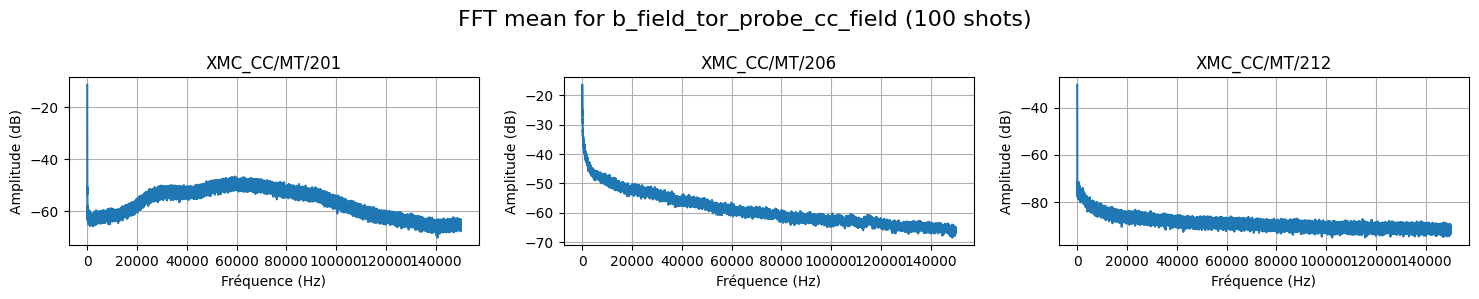

Processing shots:  22%|██▏       | 22/100 [00:40<02:08,  1.65s/it]

Error during processing shot 12720: "No variable named 'b_field_pol_probe_omv_voltage'. Did you mean one of ('b_field_pol_probe_obv_channel', 'b_field_tor_probe_saddle_voltage', 'b_field_pol_probe_obv_field', 'b_field_pol_probe_obr_channel', 'b_field_pol_probe_obr_field', 'b_field_pol_probe_ccbv_channel', 'b_field_pol_probe_ccbv_field', 'b_field_tor_probe_saddle_voltage_channel', 'b_field_tor_probe_saddle_field')?"


Processing shots:  53%|█████▎    | 53/100 [01:36<01:08,  1.46s/it]

Error during processing shot 12736: "No variable named 'b_field_pol_probe_omv_voltage'. Did you mean one of ('b_field_pol_probe_obv_channel', 'b_field_tor_probe_saddle_voltage', 'b_field_pol_probe_obv_field', 'b_field_pol_probe_obr_channel', 'b_field_pol_probe_obr_field', 'b_field_pol_probe_ccbv_channel', 'b_field_pol_probe_ccbv_field', 'b_field_tor_probe_saddle_voltage_channel', 'b_field_tor_probe_saddle_field')?"


Processing shots: 100%|██████████| 100/100 [03:05<00:00,  1.86s/it]


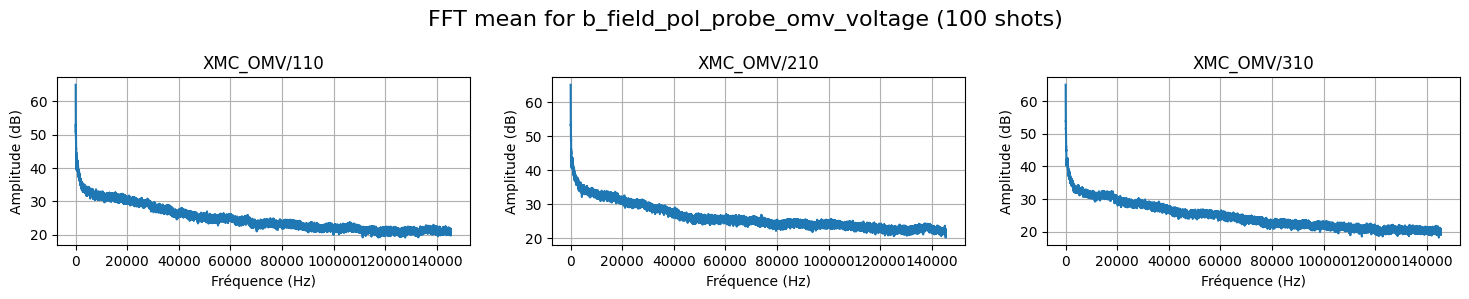

Processing shots: 100%|██████████| 100/100 [04:48<00:00,  2.89s/it]
/tmp/ipykernel_2835299/2873808131.py:117: RuntimeWarning: Mean of empty slice
  mean_fft_db.append(np.nanmean(channel_fft, axis=0))


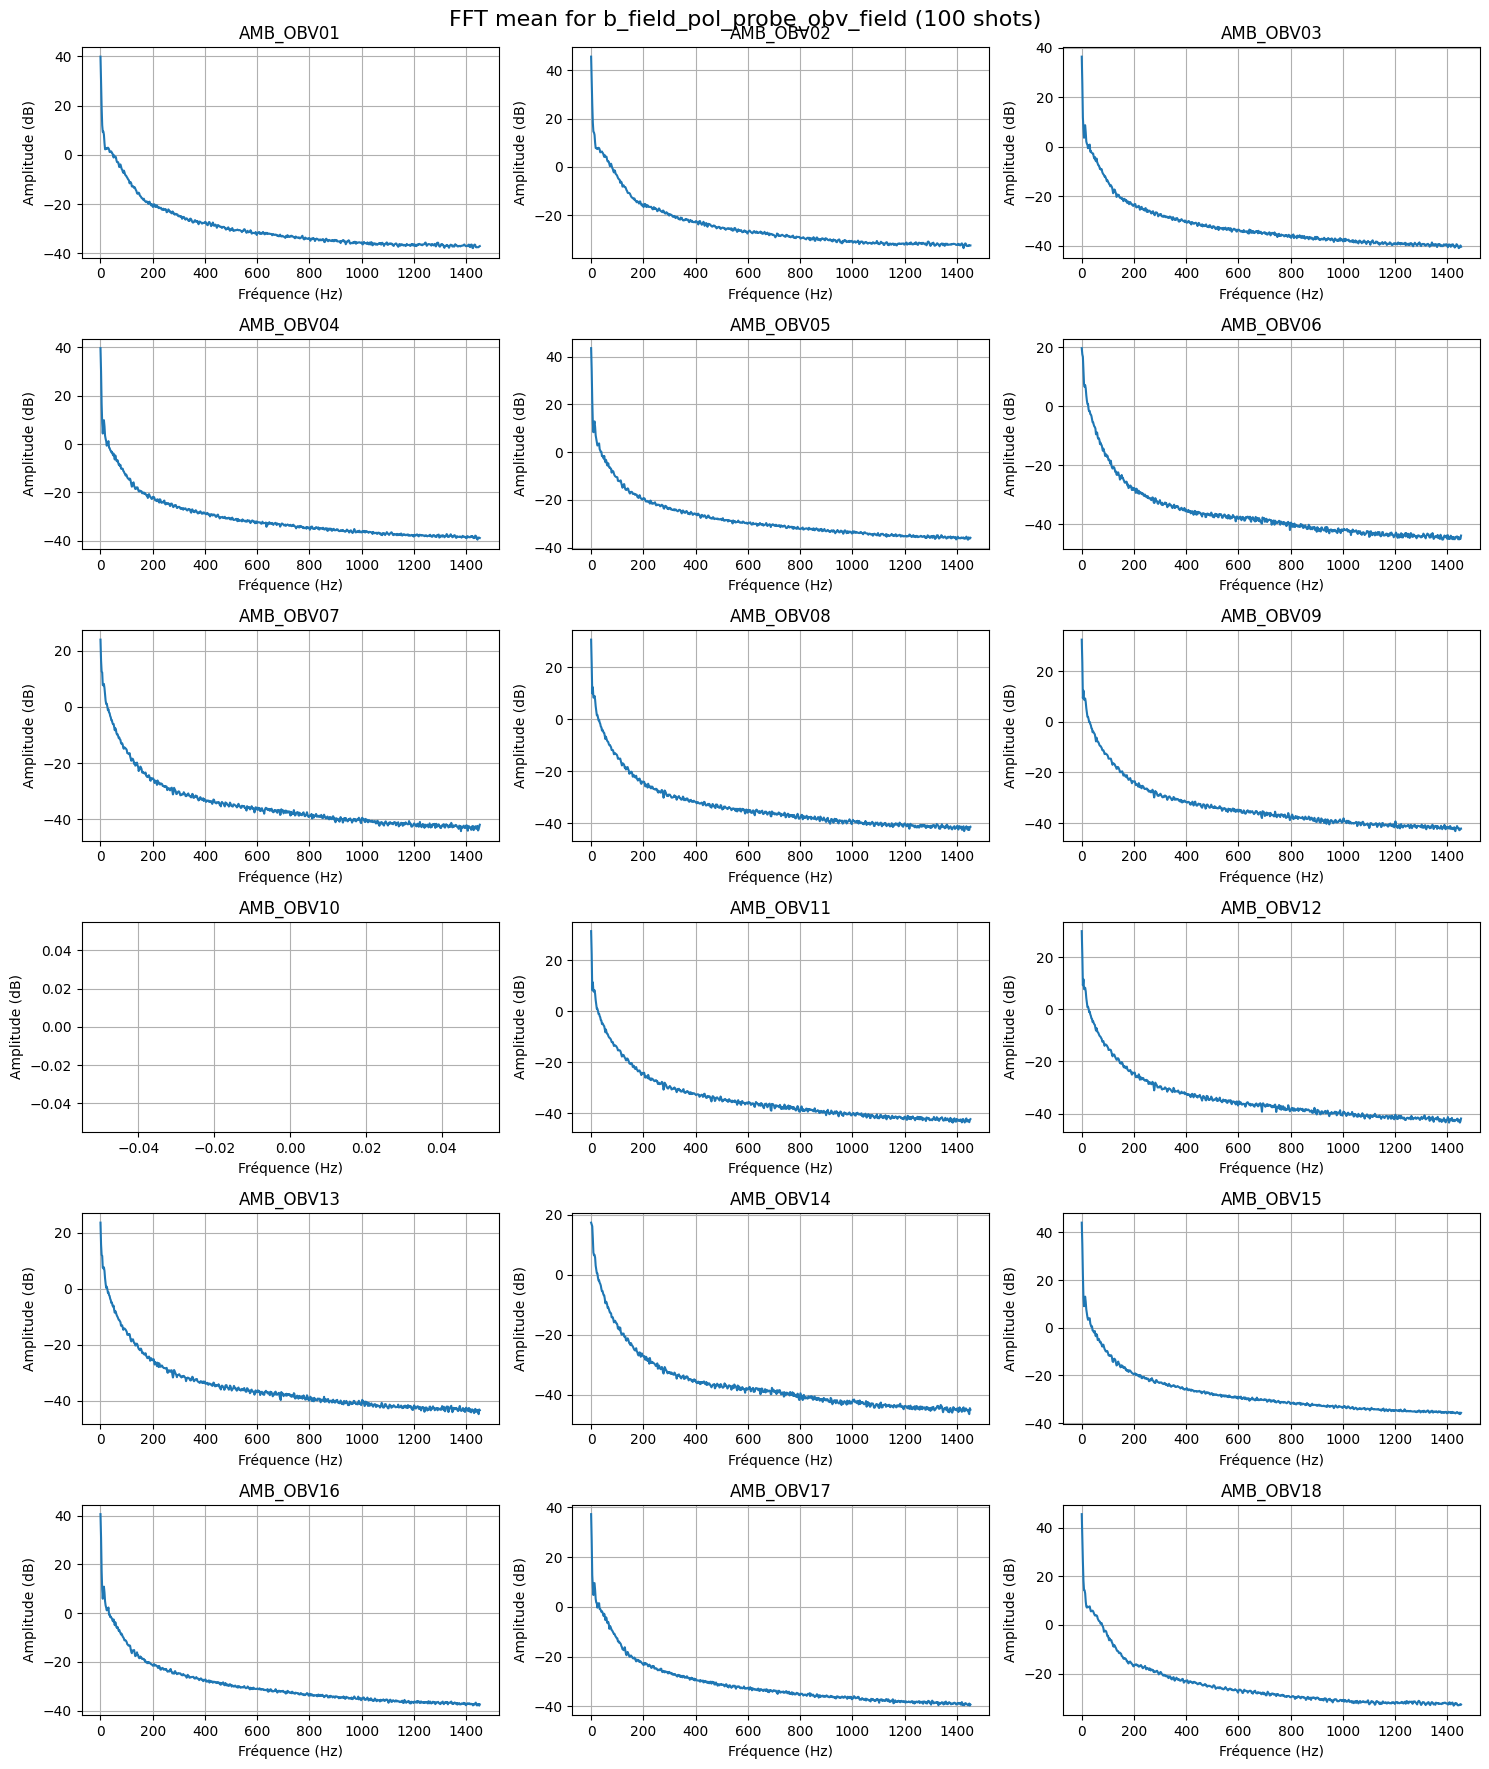

Processing shots: 100%|██████████| 100/100 [04:56<00:00,  2.96s/it]


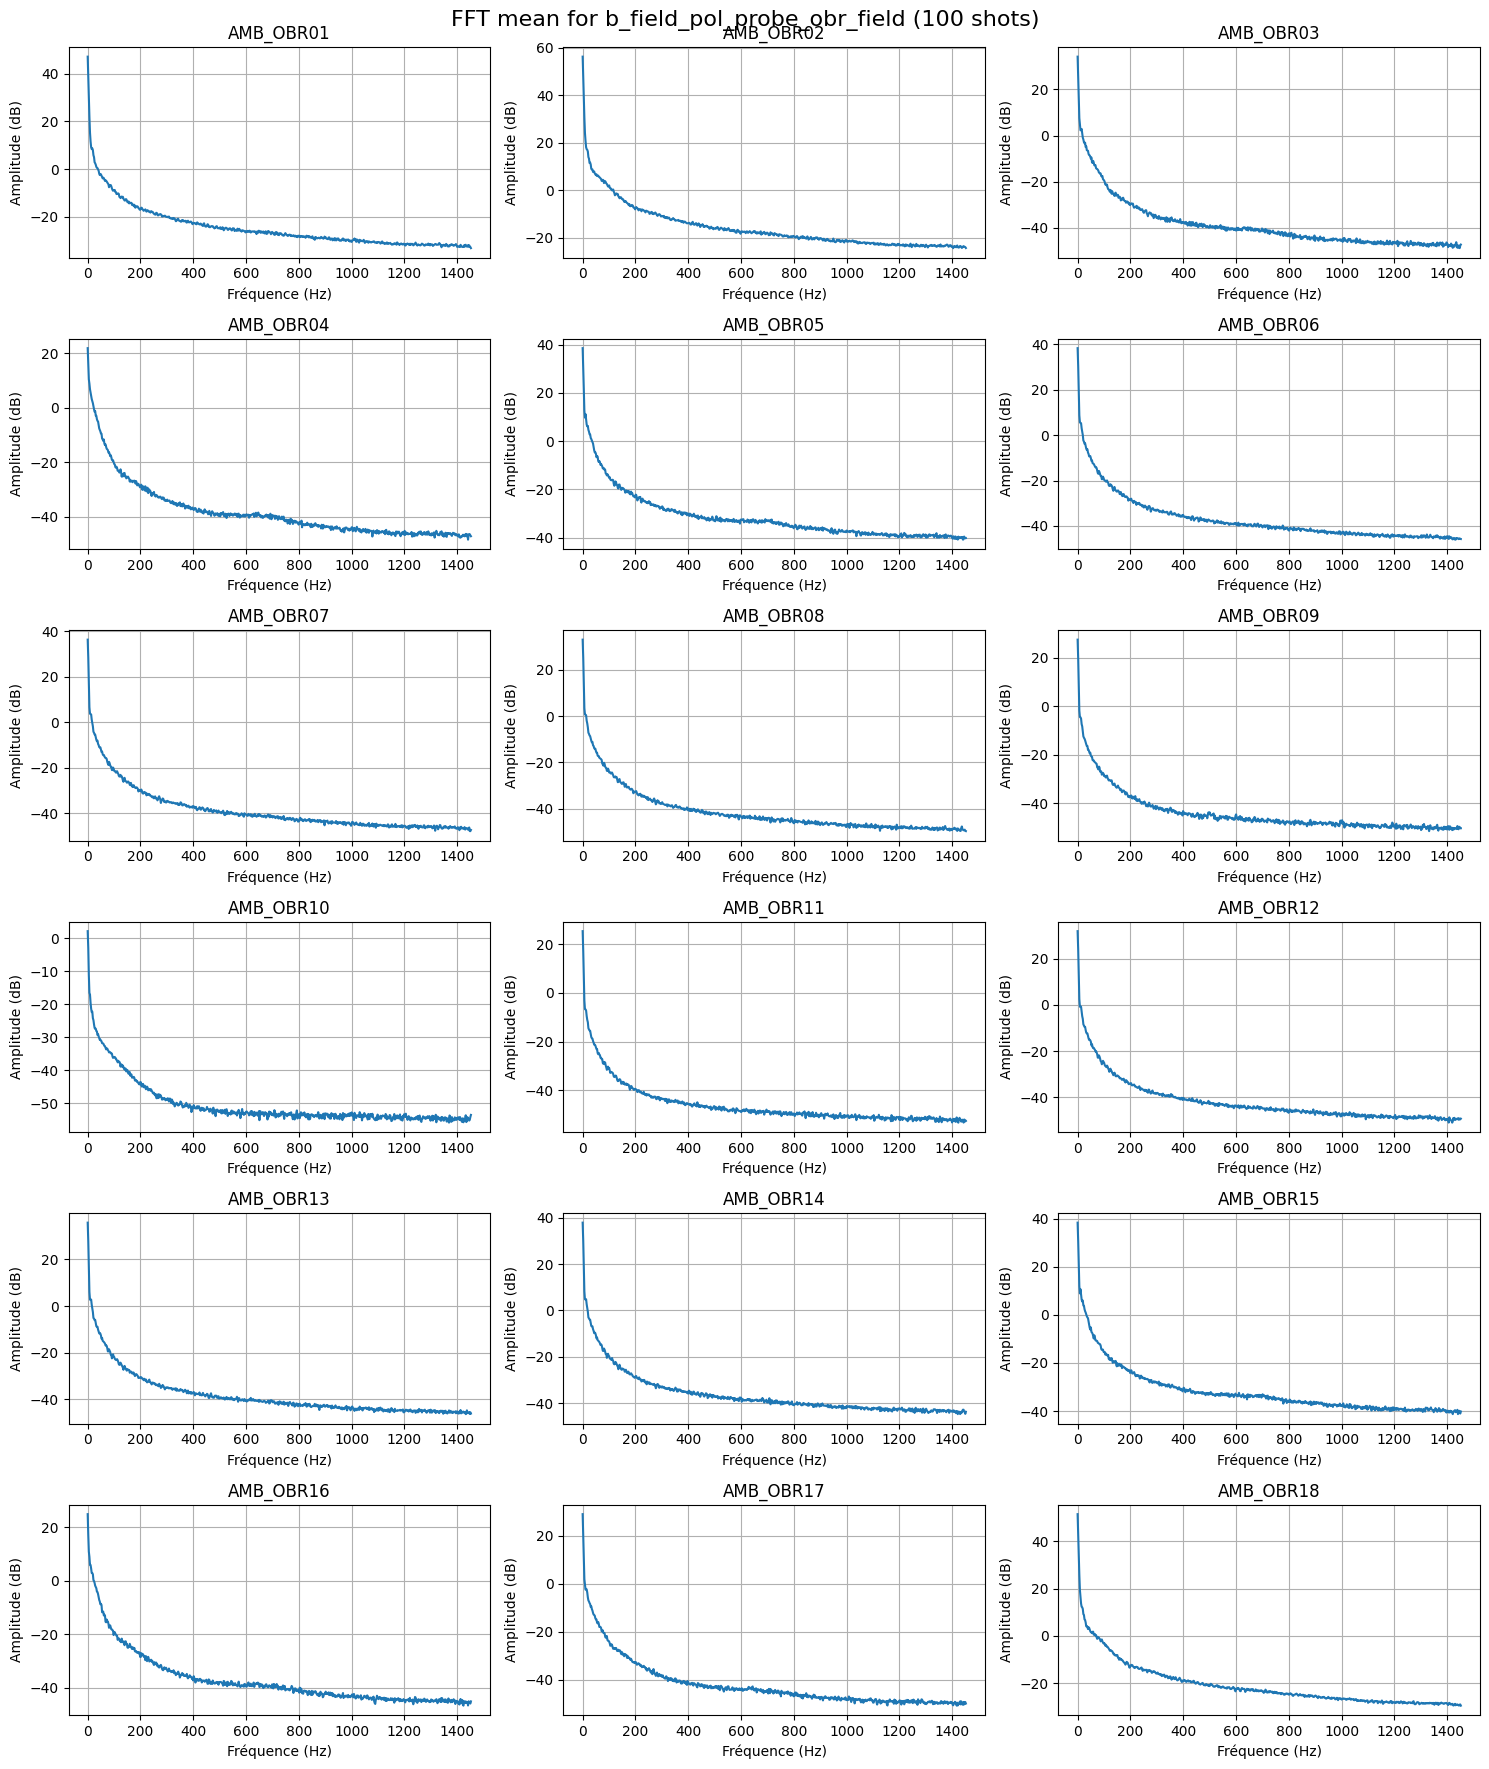

Processing shots: 100%|██████████| 100/100 [07:09<00:00,  4.29s/it]


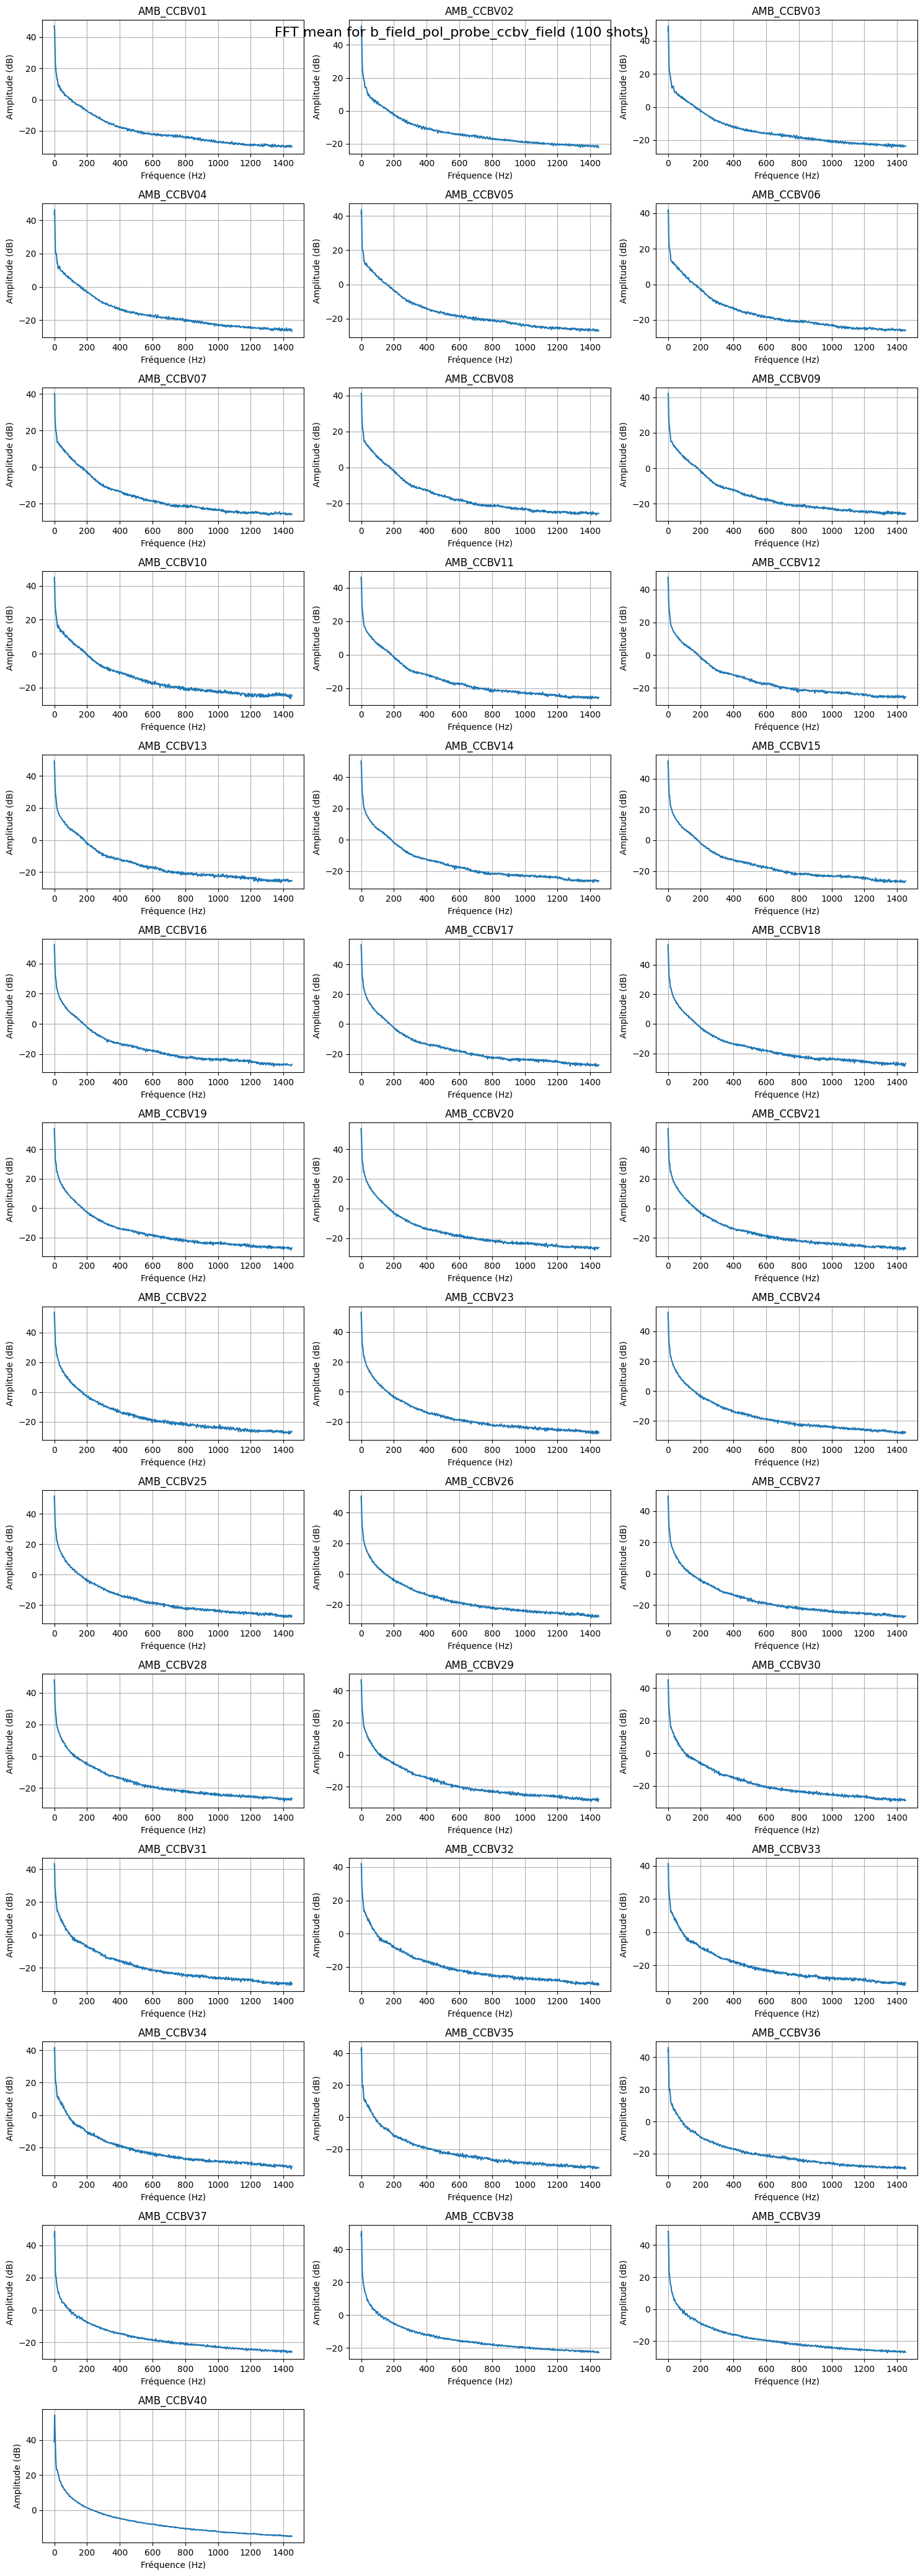

Processing shots:  22%|██▏       | 22/100 [00:56<02:49,  2.17s/it]

Error during processing shot 12720: "No variable named 'b_field_pol_probe_cc_field'. Did you mean one of ('b_field_pol_probe_ccbv_field', 'b_field_pol_probe_obv_field', 'b_field_pol_probe_obr_field', 'b_field_pol_probe_ccbv_channel', 'b_field_tor_probe_saddle_field', 'b_field_pol_probe_obv_channel', 'b_field_pol_probe_obr_channel', 'b_field_tor_probe_saddle_field_channel')?"


Processing shots:  53%|█████▎    | 53/100 [02:10<01:29,  1.90s/it]

Error during processing shot 12736: "No variable named 'b_field_pol_probe_cc_field'. Did you mean one of ('b_field_pol_probe_ccbv_field', 'b_field_pol_probe_obv_field', 'b_field_pol_probe_obr_field', 'b_field_pol_probe_ccbv_channel', 'b_field_tor_probe_saddle_field', 'b_field_pol_probe_obv_channel', 'b_field_pol_probe_obr_channel', 'b_field_tor_probe_saddle_field_channel')?"


Processing shots: 100%|██████████| 100/100 [04:05<00:00,  2.46s/it]


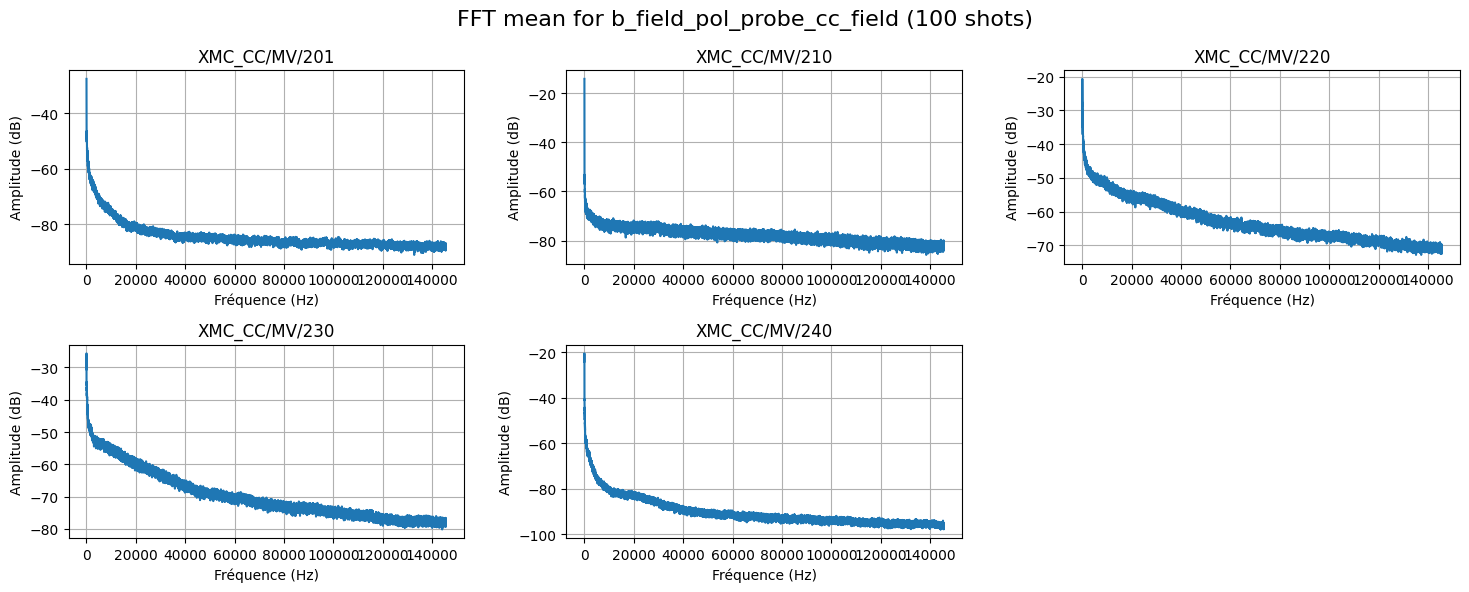

In [ ]:
_, _, _ = plot_mean_fft_variable(list_shot, 'ip', save=False)
_, _, _ = plot_mean_fft_variable(list_shot, 'flux_loop_flux', save=False)
_, _, _ = plot_mean_fft_variable(list_shot, 'b_field_tor_probe_saddle_voltage', save=False)
_, _, _ = plot_mean_fft_variable(list_shot, 'b_field_tor_probe_saddle_field', save=False)
_, _, _ = plot_mean_fft_variable(list_shot, 'b_field_tor_probe_cc_field', save=False)
_, _, _ = plot_mean_fft_variable(list_shot, 'b_field_pol_probe_omv_voltage', save=False)
_, _, _ = plot_mean_fft_variable(list_shot, 'b_field_pol_probe_obv_field', save=False)
_, _, _ = plot_mean_fft_variable(list_shot, 'b_field_pol_probe_obr_field', save=False)
_, _, _ = plot_mean_fft_variable(list_shot, 'b_field_pol_probe_ccbv_field', save=False)
_, _, _ = plot_mean_fft_variable(list_shot, 'b_field_pol_probe_cc_field', save=False)
